# Capstone Project - Product Recommendation System using Sentiment Analysis
##### Submitted by: Ayush Mandowara



# Problem Statement
The e-commerce business is quite popular today. Here, you do not need to take orders by going to each customer. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra, Paytm and Snapdeal.

 

Suppose you are working as a Machine Learning Engineer in an e-commerce company named 'Ebuss'. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

 

With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

 

As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings. 

 

In order to do this, you planned to build a sentiment-based product recommendation system, which includes the following tasks.

- Data sourcing and sentiment analysis
- Building a recommendation system
- Improving the recommendations using the sentiment analysis model
- Deploying the end-to-end project with a user interface

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import nltk
import ssl
from nltk.util import ngrams

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('stopwords')

from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler

# !pip install xgboost
import xgboost as xgb
# !pip install wordcloud
from wordcloud import WordCloud

import joblib

[nltk_data] Downloading package punkt to /Users/ayush/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ayush/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# function for printing columns with their percentage missing values
def print_missing_val_percent_in_cols(df):
    for col in df.columns:
        missing_percent = df[col].isnull().sum() / df.shape[0] * 100
        print('{}: {}'.format(col, round(missing_percent, 2)))
        
# function to return the columns with missing values
def find_missing_val_cols(df):
    missing_val_cols = []
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            missing_val_cols.append(col)
    return missing_val_cols

# function to return columns of the dataframe containing string x
def get_cols(df, x):
    x_cols = []
    for col in df.columns:
        if x in col:
            x_cols.append(col)
    return x_cols

def get_data_missing_cols(df):
    data_missing_cols = []
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if 'num_of_days' not in col:
                data_missing_cols.append(col)
            print(col, round(df[col].isnull().sum() / len(df) * 100, 2))
    return data_missing_cols

def divide_columns_based_on_number_of_unique_values(df, num_unique_vals):
    col_large_unique = []
    col_small_unique = []
    for col in df:
        if len(df[col].unique()) > num_unique_vals:
            col_large_unique.append(col)
        else:
            col_small_unique.append(col)

    print(f'more than {num_unique_vals} unique values:\nlist: {col_large_unique} \ntotal columns: {len(col_large_unique)}')
    print()

    print(f'less than {num_unique_vals} unique values:\nlist: {col_small_unique} \ntotal columns: {len(col_small_unique)}')
    print()
    
    return col_large_unique, col_small_unique

def plot_small(df, column):
    '''Common plot function for columns with small number of unique values'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    sns.countplot(x = column, data=df, ax=ax1)
    df[column].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%')
    plt.suptitle(f"{column} [dtype: {df[column].dtype}]")
    plt.savefig(f"{column}.png")
    plt.show()
    
    print(df[column].value_counts().to_string())

def plot_large(df, column):
    '''Common plot function for columns with large number of unique values'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
    plt.suptitle(f"{column} [dtype: {df[column].dtype}]")
    try:
        sns.histplot(df[column], bins=50, ax=ax1)
        ax1.set_xticks(ax1.get_xticklabels(), rotation=90)
    except:
        pass
    try:
        sns.kdeplot(x=column, data=df, ax=ax2)
    except:
        pass
    try:            
        sns.boxplot(x=column, data=df, ax=ax3)
    except:
        pass
    # plt.savefig(f"{column}.png")
    plt.show()
    print(df[column].describe().to_string())
    print()


# function to generate all the concerned evaluation metrics for a model
model_scores_dict = {}
def classification_metrics(y_actual, y_pred, model_name_key=None):
    
    confusion_mat = metrics.confusion_matrix(y_actual, y_pred)
    TP = confusion_mat[1,1] # true positive 
    TN = confusion_mat[0,0] # true negatives
    FP = confusion_mat[0,1] # false positives
    FN = confusion_mat[1,0] # false negatives

    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    accuracy = metrics.accuracy_score(y_actual, y_pred)
    precision = metrics.precision_score(y_actual, y_pred)
    recall = metrics.recall_score(y_actual, y_pred)
    TPR = sensitivity
    FNR = FN/(TP+FN)
    FPR = FP/(FP+TN)
    f1 = metrics.f1_score(y_actual, y_pred)
    
    clf_data = [[sensitivity, specificity, accuracy, precision, recall, TPR, FNR, FPR, f1]]
    clf_df = pd.DataFrame(clf_data, columns=['sensitivity', 'specificity', 'accuracy', 'precision', 'recall', 'TPR', 'FNR', 'FPR', 'F1_score'])
    clf_df = round(clf_df, 2)
    
    if model_name_key:
        model_scores_dict[model_name_key] = np.round(np.array(clf_data[0]),2)
    return clf_df

def draw_roc(actual, probs):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None


# function to genarate Churn labels from the class probability for all the given thresholds
def generate_prob_threshold_df(y_actual, y_pred_prob, thresholds):
    
    y_pred_prob = y_pred_prob[:, 1]
    # thresholds = np.round(np.arange(0, 1, 0.1), 2)
    threshold_df = pd.DataFrame(list(zip(y_actual, y_pred_prob)), columns=['Actual Churn', 'Probability'])
    
    for i in thresholds:
        churn_pred = [1 if p >= i else 0 for p in y_pred_prob]
        threshold_df[i] = churn_pred
    
    return threshold_df

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
def generate_optimal_cutoff_df(threshold_df, thresholds):
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

    for i in thresholds:
        cm1 = metrics.confusion_matrix(threshold_df['Actual Churn'], threshold_df[i])
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1

        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    return cutoff_df

# function to find optimal cut off point
def metrics_on_different_thresholds(y_actual, thresholds, threshold_df):
    '''Helper function to find optimal cut off point by try various thresholds'''
    joined_df = pd.DataFrame(columns=['sensitivity', 'specificity', 'accuracy', 'precision', 'recall', 'TPR', 'FNR', 'FPR', 'F1_score'])
    for i in thresholds:
        joined_df = pd.concat([joined_df, classification_metrics(y_actual, threshold_df[i])])
    joined_df = joined_df.set_index(thresholds)
    return joined_df

## Loading Data

In [3]:
df = pd.read_csv('sample30.csv')

## EDA

In [4]:
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [6]:
df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [7]:
df.reviews_didPurchase.value_counts()

False    14498
True      1434
Name: reviews_didPurchase, dtype: int64

In [8]:
df.shape

(30000, 15)

In [9]:
df.describe()

,reviews_rating
count,30000.000000
mean,4.483133
std,0.988441
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [10]:
df['id'].value_counts()

AVpf3VOfilAPnD_xjpun    8545
AVpfPaoqLJeJML435Xk9    3325
AVpfJP1C1cnluZ0-e3Xy    2039
AVpfW8y_LJeJML437ySW    1186
AVpfRTh1ilAPnD_xYic2    1143
                        ... 
AVpfP-rELJeJML435jEN       1
AVpfbpzd1cnluZ0-kqJV       1
AVpfbjraLJeJML439F91       1
AVpfa1joLJeJML4385hb       1
AV13O1A8GV-KLJ3akUyj       1
Name: id, Length: 271, dtype: int64

In [11]:
df['brand'].value_counts()

Clorox                   10585
Warner Home Video         3325
Disney                    1200
L'oreal Paris             1186
FOX                        887
                         ...  
Pacific Natural Foods        1
Noosa                        1
Southern Enterprises         1
SLOAN VALVE COMPANY          1
Universal Music              1
Name: brand, Length: 214, dtype: int64

In [12]:
df.nunique()

id                        271
brand                     214
categories                270
manufacturer              227
name                      271
reviews_date             6857
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            27282
reviews_title           18535
reviews_userCity          977
reviews_userProvince       42
reviews_username        24914
user_sentiment              2
dtype: int64

In [13]:
df['user_sentiment'].value_counts()

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64

In [14]:
df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [15]:
df[df['manufacturer'].isnull()].head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
22210,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2013-03-05T00:00:00.000Z,NaN,False,1,I have read the entire Alex Cross series and I...,Disappointing casting,NaN,NaN,poorcrossing,Negative
22211,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2013-10-11T00:00:00.000Z,NaN,False,1,Idris Elba was originally cast in the lead rol...,Atrocious casting,NaN,NaN,naberios,Positive
22212,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2017-06-11T00:00:00.000Z,NaN,False,2,I was way more excited or this movie than I sh...,Meh,NaN,NaN,jz30,Positive
22213,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2014-12-27T00:00:00.000Z,NaN,False,2,I'm a huge fan of James Patterson and although...,Disappointing Movie,NaN,NaN,david,Positive
22214,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2015-12-26T20:30:31.000Z,NaN,True,3,"not as exciting as the book, but very good",Alex Cross Dvd,NaN,NaN,bobc,Positive


## Null Value Analysis

In [16]:
df.isnull().mean().round(4).mul(100).sort_values(ascending=False)

reviews_userProvince    99.43
reviews_userCity        93.57
reviews_didPurchase     46.89
reviews_doRecommend      8.57
reviews_title            0.63
manufacturer             0.47
reviews_username         0.21
reviews_date             0.15
id                       0.00
brand                    0.00
categories               0.00
name                     0.00
reviews_rating           0.00
reviews_text             0.00
user_sentiment           0.00
dtype: float64

In [17]:
df[df['reviews_username'].isnull()].head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
1453,AVpe_N91LJeJML43z4jD,Way Basics,"Home,Kids' Home,Girls' Room,Girls' Room Furnit...",Way Basics,Way Basics 3-Shelf Eco Narrow Bookcase Storage...,2011-07-08T00:00:00Z,NaN,NaN,4,"We like this shelf, and found it relatively ea...",Way Basics 3-Shelf Storage Unit in Espresso Wo...,NaN,NaN,NaN,Positive
1531,AVpe_y-I1cnluZ0-bmvh,Yes to Carrots,"Personal Care,Bath, Shower & Soap,Body Wash & ...",Yes To Inc.,Yes To Carrots Nourishing Body Wash,2011-10-30T05:00:00Z,NaN,NaN,5,I'm very sensitive to fragrance - most give me...,Wonderful,NaN,NaN,NaN,Positive


#### Decison
- Dropping the user province and user city columns as they have more than 90% values missing
- Dropping the "didPurchase" column for now as it has more than 50% data missing. 
    - We can give more weightage to those reviews where the user actually purchased the product
    - However, that can be part of phase 2. especially due to missing value count being so high

In [18]:
df.drop(['reviews_didPurchase', 'reviews_userProvince', 'reviews_userCity'], axis=1, inplace=True)

In [19]:
df.isnull().mean().round(4).mul(100).sort_values(ascending=False)

reviews_doRecommend    8.57
reviews_title          0.63
manufacturer           0.47
reviews_username       0.21
reviews_date           0.15
id                     0.00
brand                  0.00
categories             0.00
name                   0.00
reviews_rating         0.00
reviews_text           0.00
user_sentiment         0.00
dtype: float64

In [20]:
df[df['reviews_title'].isnull()].head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
1239,AV1YneDPglJLPUi8IJyQ,Finish,"Household Essentials,Cleaning Supplies,Dish De...",Reckitt Benckiser,"Finish Quantum Dishwasher Detergent, Lemon Spa...",2017-11-16T08:12:30.000Z,True,5,Great quality and a great price,NaN,queen 79,Positive
1441,AVpe_dxlilAPnD_xSiHI,The Seaweed Bath Co.,"Personal Care,Hair Care,Conditioner,Beauty,Sha...",The Seaweed Bath,"The Seaweed Bath Co. Argan Conditioner, Smooth...",2013-11-07T00:00:00Z,NaN,3,Wanted to love this but it's a bit too heavy f...,NaN,julie,Positive
1442,AVpe_dxlilAPnD_xSiHI,The Seaweed Bath Co.,"Personal Care,Hair Care,Conditioner,Beauty,Sha...",The Seaweed Bath,"The Seaweed Bath Co. Argan Conditioner, Smooth...",2015-02-09T00:00:00Z,NaN,3,I have thick coarse hair and for me this just ...,NaN,lisa,Negative
1443,AVpe_dxlilAPnD_xSiHI,The Seaweed Bath Co.,"Personal Care,Hair Care,Conditioner,Beauty,Sha...",The Seaweed Bath,"The Seaweed Bath Co. Argan Conditioner, Smooth...",2013-11-07T00:00:00Z,NaN,3,Wanted to love this but it's a bit too heavy f...,NaN,julie,Positive
1444,AVpe_dxlilAPnD_xSiHI,The Seaweed Bath Co.,"Personal Care,Hair Care,Conditioner,Beauty,Sha...",The Seaweed Bath,"The Seaweed Bath Co. Argan Conditioner, Smooth...",2017-11-27T18:18:38.000Z,True,4,I actually really enjoy this conditioner. Have...,NaN,aland,Positive


In [21]:
df[~df['reviews_title'].isnull()].head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


In [22]:
df[df['id']=='AV16khLE-jtxr-f38VFn']

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative
5,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-20T00:00:00.000Z,False,1,My boyfriend and I bought this to spice things...,Not worth it,samantha,Negative
6,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-08T00:00:00.000Z,False,1,Bought this earlier today and was excited to c...,Disappointing,raeanne,Negative
7,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-21T00:00:00.000Z,False,1,I bought this product for my husband and I to ...,Not happy at all,kimmie,Negative
8,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-03-28T00:00:00.000Z,False,1,My husband and I bought this for some extra fu...,Very disappointing,cassie,Negative
9,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-03-21T00:00:00.000Z,False,1,Got as a surprise for my husband there is noth...,Don't buy,moore222,Positive
10,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-08T00:00:00.000Z,False,1,tried it with my husband and felt no different...,pretty dissapoitned,jds1992,Negative
11,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-05T00:00:00.000Z,False,1,Purchased this thinking it would have some sor...,Waste of Money,bre234,Positive
12,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-08T00:00:00.000Z,False,1,"Bought this to enhance our time a bit, did abs...",waste of money,jds1992,Negative


#### ID column doesn't seem to be off much use so dropping it
- Looks like it corresponds to the product names like a unique id for the product name. We'll use the 'product name' column instead as it would be more descriptive.

In [23]:
df.drop('id', axis=1, inplace=True)

In [24]:
df.head(2)

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive


In [25]:
df.loc[4]['reviews_text']

"My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel."

In [26]:
df.loc[4]

brand                                                                K-Y
categories             Personal Care,Medicine Cabinet,Lubricant/Sperm...
manufacturer                                                         K-Y
name                                    K-Y Love Sensuality Pleasure Gel
reviews_date                                    2016-12-21T00:00:00.000Z
reviews_doRecommend                                                False
reviews_rating                                                         1
reviews_text           My husband bought this gel for us. The gel cau...
reviews_title                                                 Irritation
reviews_username                                               walker557
user_sentiment                                                  Negative
Name: 4, dtype: object

In [27]:
df.loc[20]['reviews_text']

"I noticed this product on clearance at a store I shop frequently and decided to give it a try. My husband and I LOVE it! We went back and bought every box left! I, like others have mentioned, am not sure what it is supposed to do other than be a lubricant but for that purpose we like it much better than regular KY Jelly (which tends to dry out and disappear for us). This product stays on for awhile and makes for a very pleasurable experience. The only drawback is that we find it to be a bit sticky. After applying it with your hands you're left with a sticky hand and I agree a little goes a long way! I personally have to be very careful with all products due to skin irritation and surprisingly this actually seems to help that. I did NOT receive a sample and never have."

In [28]:
df.tail(3)

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
29997,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-21T00:00:00.000Z,True,5,First of all I love the smell of this product....,Hair is so smooth after use,liviasuexo,Positive
29998,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-11T00:00:00.000Z,True,5,I received this through Influenster and will n...,Perfect for my oily hair!,ktreed95,Positive
29999,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-19T00:00:00.000Z,True,5,I received this product complimentary from inf...,Conditioned into healthy,kcoopxoxo,Positive


In [29]:
df.loc[29997]['reviews_text']

'First of all I love the smell of this product. After you wash your hair it is so smooth and easy to brush! I did receive this product from influenster for testing purposes but all opinions ARE my own! This review was collected as part of a promotion.'

In [30]:
df.loc[29998]['reviews_text']

"I received this through Influenster and will never go back to anything else! I normally don't use conditioner because my hair is so oily and fine. This does not make my hair feel heavy, and it doesn't get oily during the day! It really is fantastic and plan on buying it in the future! This review was collected as part of a promotion."

In [31]:
df[df['reviews_text'].str.contains('This review was collected as part of a promotion')]

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
23,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2017-08-15T00:00:00.000Z,NaN,5,Loved This review was collected as part of a p...,Loved,ashley a,Positive
41,Johnson's,"Personal Care,Baby Care,Baby Bubble Bath,Baby,...",Johnson's,"Johnson's Baby Bubble Bath and Wash, 15oz",2017-04-05T00:00:00.000Z,NaN,2,"I did receive 1 bottle but when I ordered, it ...",Not the quantity specifed,nyisha m,Negative
68,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2015-06-05T00:00:00.000Z,True,3,Love it. I can feel the result in few days. I ...,very soft,leni,Positive
69,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2015-06-01T00:00:00.000Z,True,3,I use this at night for wrinkles on the face. ...,reduces wrinkles,silvereagle,Positive
...,...,...,...,...,...,...,...,...,...,...,...
29994,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-14T00:00:00.000Z,True,5,I got to try this conditioner for free and boy...,"By far, my new favorite conditioner",smartthunny,Positive
29995,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-23T00:00:00.000Z,True,5,I got this conditioner with Influenster to try...,Softness!!,laurasnchz,Positive
29997,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-21T00:00:00.000Z,True,5,First of all I love the smell of this product....,Hair is so smooth after use,liviasuexo,Positive
29998,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-11T00:00:00.000Z,True,5,I received this through Influenster and will n...,Perfect for my oily hair!,ktreed95,Positive


In [32]:
df.loc[41]['reviews_text']

'I did receive 1 bottle but when I ordered, it said a pack of 6. I was disappointed about that. This review was collected as part of a promotion.'

In [33]:
df.shape

(30000, 11)

#### Missing Review Titles 
- After taking a look at a couple of review texts and corresponding titles above, it seems that most titles just have some words from the review text itself or the title just compliments the text.

For further analysis, there are 2 approaches
1. drop review titles column
2. combine review titles and reviews text together into a single column

#### Decision 
I'm inclined towards dropping the title column since it has redundant information

In [34]:
df.drop('reviews_title', axis=1, inplace=True)

In [35]:
df.head(2)

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
0,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,5,i love this album. it's very good. more to the...,joshua,Positive
1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor. This review was collected as part...,dorothy w,Positive


In [36]:
df.isnull().sum()

brand                     0
categories                0
manufacturer            141
name                      0
reviews_date             46
reviews_doRecommend    2570
reviews_rating            0
reviews_text              0
reviews_username         63
user_sentiment            1
dtype: int64

In [37]:
df[df['user_sentiment'].isnull()]

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
28354,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00.000Z,True,5,my kids absolutely loved this film so much tha...,7.87E+11,NaN


In [38]:
df.loc[28354]['reviews_text']

'my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy'

In [39]:
df['reviews_username'].nunique()

24914

In [40]:
df['reviews_username'].head()

0       joshua
1    dorothy w
2    dorothy w
3      rebecca
4    walker557
Name: reviews_username, dtype: object

In [41]:
df['reviews_username'].tail()

29995       laurasnchz
29996    scarlepadilla
29997       liviasuexo
29998         ktreed95
29999        kcoopxoxo
Name: reviews_username, dtype: object

In [42]:
df[df['reviews_username']=='7.87E+11']

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
27254,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2015-01-17T00:00:00.000Z,False,3,I watched the movie from beginning to end. It ...,7.87E+11,Positive
28354,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00.000Z,True,5,my kids absolutely loved this film so much tha...,7.87E+11,NaN


#### Note
- The above username is super strange (it's more like a number) but I will let it go for now.
- Further, it does seem like there are duplicate records, so I'll clean those up.

#### Removing Duplicates

In [43]:
df[df.duplicated()].shape

(52, 10)

In [44]:
df[df.duplicated(keep=False)].head(4)

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
67,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T03:08:38.000Z,True,3,Today is my first time using this product. Fel...,mylifeinheels,Positive
90,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T03:08:38.000Z,True,3,Today is my first time using this product. Fel...,mylifeinheels,Positive
1281,Meguiars,"Home,Home Improvement,Automotive,Car Cleaning,...",Parts,Meguiar's Deep Crystal Car Wash 64-Oz.,2017-02-16T21:47:38.000Z,True,5,Meguiar's Deep Crystal Car Wash 64-oz. is top ...,synoptic 12,Positive
1282,Meguiars,"Home,Home Improvement,Automotive,Car Cleaning,...",Parts,Meguiar's Deep Crystal Car Wash 64-Oz.,2017-02-16T21:47:38.000Z,True,5,Meguiar's Deep Crystal Car Wash 64-oz. is top ...,synoptic 12,Positive


In [45]:
df[df['reviews_username']=='mylifeinheels']

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
67,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T03:08:38.000Z,True,3,Today is my first time using this product. Fel...,mylifeinheels,Positive
79,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T00:00:00.000Z,True,3,Today is my first time using this product. Fel...,mylifeinheels,Positive
90,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T03:08:38.000Z,True,3,Today is my first time using this product. Fel...,mylifeinheels,Positive


In [46]:
df.drop_duplicates(keep='first', inplace=True)

In [47]:
df.shape

(29948, 10)

##### Making sure we have kept one of the duplicates in above operation

In [48]:
df[df['reviews_username']=='mylifeinheels']

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
67,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T03:08:38.000Z,True,3,Today is my first time using this product. Fel...,mylifeinheels,Positive
79,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T00:00:00.000Z,True,3,Today is my first time using this product. Fel...,mylifeinheels,Positive


In [49]:
df.loc[67]['reviews_text']

'Today is my first time using this product. Felt great going on immediately, felt moisturized without being too greasy. Although it smells great I would have loved to have this formula in a fragrance-free option, my skin tends to be a little sensitive to fragrances, but I will give a final review in a couple of weeks'

In [50]:
df.loc[79]['reviews_text']

'Today is my first time using this product. Felt great going on immediately, felt moisturized without being too greasy. Although it smells great I would have loved to have this formula in a fragrance-free option, my skin tends to be a little sensitive to fragrances, but I will give a final review in a couple of weeks'

In [51]:
df.loc[67]['reviews_text'] == df.loc[79]['reviews_text']

True

#### Looks like there are duplicate reviews made on different times as well. 

In [52]:
df.duplicated(subset=['reviews_text', 'reviews_username', 'name']).sum()

1743

In [53]:
df[df.duplicated(subset=['reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'reviews_date'], keep=False)]

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
4143,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover,Hoover174 Platinum Collection153 Lightweight B...,2011-10-01T00:00:00.000Z,False,1,Loved this machine until I replaced my worn ou...,tired arms,Positive
4151,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover,Hoover174 Platinum Collection153 Lightweight B...,2011-10-01T00:00:00.000Z,NaN,1,Loved this machine until I replaced my worn ou...,tired arms,Positive
15026,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2009-08-12T00:00:00.000Z,NaN,3,I use indexes as I prepare various notebooks f...,peterwatts,Positive
15027,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2009-08-12T00:00:00.000Z,False,3,I use indexes as I prepare various notebooks f...,peterwatts,Positive
15076,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2011-12-05T00:00:00.000Z,NaN,5,These dividers are essential wherever extra di...,gellis,Positive
15130,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2016-06-15T00:00:00.000Z,NaN,5,I wish that an extra table of content sheet wa...,dave,Negative
15131,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2016-06-15T00:00:00.000Z,True,5,I wish that an extra table of content sheet wa...,dave,Negative
15198,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2011-12-05T00:00:00.000Z,False,5,These dividers are essential wherever extra di...,gellis,Positive
18577,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-08-15T00:00:00.000Z,False,1,I purchaed 12443842 for 3.28 and 25483701 for ...,loyalcustomerchicago,Positive
20483,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-08-15T00:00:00.000Z,True,5,I purchaed 12443842 for 3.28 and 25483701 for ...,loyalcustomerchicago,Positive


#### Observation
Sometimes, the same reviews have two values for reviews_doRecommend one of which is NaN.

#### Decision
In such a case, the row with NaN value should be dropped

In [54]:
df[df.duplicated(subset=['reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'reviews_date'], keep=False) & df['reviews_doRecommend'].isnull()]

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
4151,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover,Hoover174 Platinum Collection153 Lightweight B...,2011-10-01T00:00:00.000Z,NaN,1,Loved this machine until I replaced my worn ou...,tired arms,Positive
15026,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2009-08-12T00:00:00.000Z,NaN,3,I use indexes as I prepare various notebooks f...,peterwatts,Positive
15076,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2011-12-05T00:00:00.000Z,NaN,5,These dividers are essential wherever extra di...,gellis,Positive
15130,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2016-06-15T00:00:00.000Z,NaN,5,I wish that an extra table of content sheet wa...,dave,Negative


In [55]:
df.drop(df[df.duplicated(subset=['reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'reviews_date'], keep=False) & df['reviews_doRecommend'].isnull()].index, inplace=True)

In [56]:
df.loc[4150:4153]

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
4150,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover,Hoover174 Platinum Collection153 Lightweight B...,2010-05-30T00:00:00.000Z,NaN,1,Impossible to push on freize carpet with moder...,vic,Positive
4152,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover,Hoover174 Platinum Collection153 Lightweight B...,2011-09-16T00:00:00.000Z,NaN,1,On sale because you cannot push it in plush ca...,NaN,Negative
4153,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover,Hoover174 Platinum Collection153 Lightweight B...,2013-06-06T14:21:58.000Z,NaN,2,"I bought this vaccum on 5-1-11, it worked fine...",jessrn,Positive


In [57]:
df[df.duplicated(subset=['reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'reviews_date'], keep=False)]

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
18577,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-08-15T00:00:00.000Z,False,1,I purchaed 12443842 for 3.28 and 25483701 for ...,loyalcustomerchicago,Positive
20483,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-08-15T00:00:00.000Z,True,5,I purchaed 12443842 for 3.28 and 25483701 for ...,loyalcustomerchicago,Positive


In [58]:
df.loc[18577].reviews_text

'I purchaed 12443842 for 3.28 and 25483701 for 6.37 - the formulas are exactly the same but the prices are drastically different! http://www.walmart.com/ip/Clorox-Disinfecting-Bathroom-Cleaner-30-Fl-Oz/12443842 http://www.walmart.com/ip/Clorox-Company-COX16930-Clorox-Disinfecting-Bathroom-Cleaner-30-oz/25483701 each bottle reads: Ative Ingredients: n-Alkyl (60 C14, 30 C16, 5 C12, 5 C18) 0.1375 dimethylbenzyl ammonium chloride n-Alkyl (68 C12, 32 C14) 0.1375 dimethyl ethlbenzyl ammonium choride 99.7250 other ingredients 100.0000 total'

#### Observation
In the above case, it seems that the customer is unhappy due to the difference in prices

#### Decision
I'll keep the review with the lower ratings.

In [59]:
df.drop(20483, inplace=True)

In [60]:
df[df.duplicated(subset=['reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'reviews_date'], keep=False)]

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment


In [61]:
df[df.duplicated(subset=['reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'manufacturer'], keep=False)].shape

(3474, 10)

In [62]:
df[df.duplicated(subset=['reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'manufacturer', 'reviews_doRecommend'], keep=False)].shape

(2694, 10)

In [63]:
df[df.duplicated(subset=['reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'manufacturer', 'reviews_doRecommend', 'reviews_rating'], keep=False)].shape

(2694, 10)

#### Observation
It seems some users have changed their ratings and reviews_doRecommend flag after giving a review

In [64]:
df[df.duplicated(subset=['reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'manufacturer', 'reviews_doRecommend', 'reviews_rating'], keep=False)].shape

(2694, 10)

In [65]:
a = df[df.duplicated(subset=['reviews_text', 'reviews_username', 'name', 'brand', 'categories', 'manufacturer'], keep=False)]

In [66]:
a.shape

(3474, 10)

In [67]:
b = a.drop_duplicates(['reviews_text', 'reviews_username', 'name', 'reviews_doRecommend'], keep='last')

In [68]:
b.shape

(2127, 10)

In [69]:
b.duplicated(['reviews_text']).sum()

391

In [70]:
b[b.duplicated(['reviews_text'], keep=False)].head()

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
716,Windex,"Household Essentials,Cleaning Supplies,Glass C...",Windex,Windex Original Glass Cleaner Refill 67.6oz (2...,2017-06-20T13:23:45.000Z,NaN,1,I have now purchased two different 23 oz bottl...,disappointedmom,Positive
728,Windex,"Household Essentials,Cleaning Supplies,Glass C...",Windex,Windex Original Glass Cleaner Refill 67.6oz (2...,2017-06-20T00:00:00.000Z,False,1,I have now purchased two different 23 oz bottl...,disappointedmom,Positive
738,Windex,"Household Essentials,Cleaning Supplies,Glass C...",Windex,Windex Original Glass Cleaner Refill 67.6oz (2...,2012-05-18T04:06:51.000Z,NaN,2,This is a great windex product that I came acr...,suri,Positive
742,Windex,"Household Essentials,Cleaning Supplies,Glass C...",Windex,Windex Original Glass Cleaner Refill 67.6oz (2...,2012-05-18T00:00:00.000Z,False,2,This is a great windex product that I came acr...,suri,Positive
1080,Aussie,"Personal Care,Hair Care,Shampoo,Beauty,Shampoo...",Aussie,"Aussie Aussome Volume Shampoo, 13.5 Oz",2015-02-14T22:37:15.000Z,NaN,3,I use this because it has very little fragranc...,kittycatty,Negative


In [71]:
b[b.duplicated(['reviews_text'], keep=False) & b['reviews_doRecommend'].isnull()]

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
716,Windex,"Household Essentials,Cleaning Supplies,Glass C...",Windex,Windex Original Glass Cleaner Refill 67.6oz (2...,2017-06-20T13:23:45.000Z,NaN,1,I have now purchased two different 23 oz bottl...,disappointedmom,Positive
738,Windex,"Household Essentials,Cleaning Supplies,Glass C...",Windex,Windex Original Glass Cleaner Refill 67.6oz (2...,2012-05-18T04:06:51.000Z,NaN,2,This is a great windex product that I came acr...,suri,Positive
1080,Aussie,"Personal Care,Hair Care,Shampoo,Beauty,Shampoo...",Aussie,"Aussie Aussome Volume Shampoo, 13.5 Oz",2015-02-14T22:37:15.000Z,NaN,3,I use this because it has very little fragranc...,kittycatty,Negative
3707,Canada Dry,"Food & Beverage,Beverages,Soda & Pop,Grocery &...","Dr Pepper/Seven Up, Inc",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,2017-07-23T20:48:35.000Z,NaN,4,I love the diet ginger ale and have been buyin...,vypkf0,Positive
4117,The Honest Company,"Household Chemicals,Laundry,Laundry Detergent,...",The Honest Company,The Honest Company Laundry Detergent,2014-06-20T00:00:00Z,NaN,5,I've been using this laundry detergent for a f...,blessedmomma,Positive
...,...,...,...,...,...,...,...,...,...,...
29479,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-02T15:48:27.000Z,NaN,4,"Out of all three, the conditioner was my favor...",tess22,Positive
29532,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-02-01T05:15:31.000Z,NaN,4,I really liked this conditioner. I got this pr...,tania13,Positive
29537,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-31T07:40:17.000Z,NaN,4,This conditioner was great - although it wasn'...,milavalle13,Positive
29549,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-29T20:32:25.000Z,NaN,4,I've been trying this for the past month and i...,rosberryyy,Positive


#### Observation
On anlayzing further, it seems that difference is again due to the "doRecommend" flag only. 

#### Decision
We'll keep only those entries where value for "doRecommend" flag value is present among the duplicate entries

In [72]:
df[
    df.duplicated(subset=['reviews_text', 'reviews_username', 'name'], keep=False) &
    df['reviews_doRecommend'].isnull()
  ].shape

(544, 10)

In [73]:
df.drop(
    df[
        df.duplicated(subset=['reviews_text', 'reviews_username', 'name'], keep=False) &
        df['reviews_doRecommend'].isnull()
  ].index, inplace=True)

In [74]:
df.shape

(29399, 10)

In [75]:
df[df.duplicated(subset=['reviews_text', 'reviews_username', 'name', 'categories', 'reviews_doRecommend', 'user_sentiment', 'reviews_date'])].shape

(0, 10)

### Observation

Only those duplicates remain where date is different.

### Decision

We'll keep only one of those entries. 

In [76]:
# df.dtypes

##### reviews_date column analysis
- converting column to date time
- checking missing value patterns

In [77]:
df['reviews_date'] = df['reviews_date'].str.replace('\..+', '', regex=True)

In [78]:
df['reviews_date'].head()

0    2012-11-30T06:21:45
1    2017-07-09T00:00:00
2    2017-07-09T00:00:00
3    2016-01-06T00:00:00
4    2016-12-21T00:00:00
Name: reviews_date, dtype: object

In [79]:
df['reviews_date'].isnull().sum()

46

In [80]:
df['reviews_date'].value_counts()[0:5]

2012-01-26T00:00:00    1039
2014-12-03T00:00:00     524
2014-09-19T00:00:00     406
2014-12-05T00:00:00     345
2014-12-04T00:00:00     301
Name: reviews_date, dtype: int64

In [81]:
df[df['reviews_date'].isnull()]

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
1536,Alberto VO5,"Personal Care,Hair Care,Shampoo,Beauty,Shampoo...",High Ridge Brands Co.,Alberto VO5 Salon Series Smooth Plus Sleek Sha...,NaN,NaN,5,FINALLY! Thank you Alberto VO5 .. You finally ...,nikolaos christodoularas,Positive
1784,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,1,"This is a real guilty pleasure.An inept, stagy...",zotox,Negative
1785,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,1,While Clambake was certainly not at the top of...,r. riis rriis,Negative
1786,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,2,I've enjoyed some of Elvis' movies like Viva L...,boomclap bikecub,Positive
1787,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,2,"Not one of Elvis's best movies, but it has som...",NaN,Positive
1788,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,2,There are basically four criteria by which I j...,eric carr-tune night creature,Positive
1789,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,2,"Being a low price DVD, you do not really expec...",paul jones,Positive
1790,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,3,...and I thought the quality was on the poor s...,suzanne m. colter,Positive
1791,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,3,"Clambake starring Elvis Presley,Shelley Fabare...",dr robert apuzzio,Positive
1792,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,4,"Like every 1966-67 Elvis movie, you have prett...",NaN,Positive


In [82]:
df[df['name'] == 'Home Health Hairever Shampoo']

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
18323,Home Health,"Personal Care,Hair Care,Shampoo,Baby,Bathing,S...",Home Health,Home Health Hairever Shampoo,2013-05-19T00:00:00Z,NaN,2,"The shampoo is hard to use, as the bottle is s...",joan kay,Negative
18324,Home Health,"Personal Care,Hair Care,Shampoo,Baby,Bathing,S...",Home Health,Home Health Hairever Shampoo,NaN,NaN,3,Did not notice much difference but then i don'...,donna,Positive
18325,Home Health,"Personal Care,Hair Care,Shampoo,Baby,Bathing,S...",Home Health,Home Health Hairever Shampoo,NaN,NaN,5,This shampoo gets your hair SUPER clean. I've ...,livinginbeauty,Positive
18326,Home Health,"Personal Care,Hair Care,Shampoo,Baby,Bathing,S...",Home Health,Home Health Hairever Shampoo,NaN,NaN,5,I've been using this for many years in conjunc...,m. galbreath,Positive


In [83]:
df[df['brand'] == 'Target.com Use Only']

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
1437,Target.com Use Only,"Movies, Music & Books,Movies,Drama,African Ame...",Xenon,Black Sister's Revenge (dvd),2016-04-25T04:01:38,True,5,Awesome movie. It was very entertaining. Dont ...,tam123,Positive
1784,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,1,"This is a real guilty pleasure.An inept, stagy...",zotox,Negative
1785,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,1,While Clambake was certainly not at the top of...,r. riis rriis,Negative
1786,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,2,I've enjoyed some of Elvis' movies like Viva L...,boomclap bikecub,Positive
1787,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,2,"Not one of Elvis's best movies, but it has som...",NaN,Positive
1788,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,2,There are basically four criteria by which I j...,eric carr-tune night creature,Positive
1789,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,2,"Being a low price DVD, you do not really expec...",paul jones,Positive
1790,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,3,...and I thought the quality was on the poor s...,suzanne m. colter,Positive
1791,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,3,"Clambake starring Elvis Presley,Shelley Fabare...",dr robert apuzzio,Positive
1792,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),NaN,NaN,4,"Like every 1966-67 Elvis movie, you have prett...",NaN,Positive


#### Observation
No connection with respect to name or brand when date is missing. It could just be a random error.

#### Decision
Filling the value with mode for now. It shouldn't impact the analysis too much since the missing values are quite low in number

In [84]:
df['reviews_date'].fillna(df['reviews_date'].mode()[0])

0        2012-11-30T06:21:45
1        2017-07-09T00:00:00
2        2017-07-09T00:00:00
3        2016-01-06T00:00:00
4        2016-12-21T00:00:00
                ...         
29995    2017-01-23T00:00:00
29996    2017-01-27T00:00:00
29997    2017-01-21T00:00:00
29998    2017-01-11T00:00:00
29999    2017-01-19T00:00:00
Name: reviews_date, Length: 29399, dtype: object

In [85]:
# pd.to_datetime(df['reviews_date'].fillna(df['reviews_date'].mode()[0]), format='%Y-%m-%dT%H:%M:%S')

In [86]:
df['reviews_date'] = df['reviews_date'].str.replace(" hooks slide or swivel into any desired position doesn't match format specified", df['reviews_date'].mode()[0])

In [87]:
# pd.to_datetime(df['reviews_date'].fillna(df['reviews_date'].mode()[0]), format='%Y-%m-%dT%H:%M:%S')

In [88]:
df['reviews_date'].fillna(df['reviews_date'].mode()[0], inplace=True)

In [89]:
df['reviews_date'].isnull().sum()

0

In [90]:
# df['reviews_date'] = pd.to_datetime(df['reviews_date'], format='%Y-%m-%dT%H:%M:%S', utc=True)

In [91]:
df.head(5)

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
0,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45,NaN,5,i love this album. it's very good. more to the...,joshua,Positive
1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00,NaN,5,Good flavor. This review was collected as part...,dorothy w,Positive
2,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00,NaN,5,Good flavor.,dorothy w,Positive
3,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00,False,1,I read through the reviews on here before look...,rebecca,Negative
4,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00,False,1,My husband bought this gel for us. The gel cau...,walker557,Negative


In [92]:
df.dtypes

brand                  object
categories             object
manufacturer           object
name                   object
reviews_date           object
reviews_doRecommend    object
reviews_rating          int64
reviews_text           object
reviews_username       object
user_sentiment         object
dtype: object

In [93]:
df.loc[28421]['name']

'Concept Housewares 36 Natural Wood ceiling mounted pot rack'

In [94]:
df[df['brand'] == 'Concept Housewares']

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
28421,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired position,True,3,We moved into a home that already had this pot...,hatestandinginlines,Positive
28422,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired position,True,5,Just bought one of these racks after first fin...,karenh2008,Positive
28423,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired position,True,5,Living in a townhome definitely has it's perks...,hellodanielle,Positive
28424,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired position,True,5,My daughter-in-law purchased this and I liked ...,laurel,Positive
28425,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired position,True,5,Heavy duty - very durable-looking. Much more t...,janet,Positive
28426,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired position,True,5,"I have a large kitchen, but over my stove wher...",cookinmama2002,Positive
28427,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired position,True,5,These units are easy to assemble sturdy and of...,projectbound,Positive
28428,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired position,True,5,i love the pot rack. it was very easy to put t...,chomie,Positive


#### Observation
- All 'Concept Housewares' have an issue with the 'reviews_date' column
- Seems like some part of description of the product got mixed into the date column
- I'll replace these entries with the mode

In [95]:
df.head()

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
0,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45,NaN,5,i love this album. it's very good. more to the...,joshua,Positive
1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00,NaN,5,Good flavor. This review was collected as part...,dorothy w,Positive
2,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00,NaN,5,Good flavor.,dorothy w,Positive
3,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00,False,1,I read through the reviews on here before look...,rebecca,Negative
4,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00,False,1,My husband bought this gel for us. The gel cau...,walker557,Negative


In [96]:
df.isnull().sum()

brand                     0
categories                0
manufacturer            141
name                      0
reviews_date              0
reviews_doRecommend    2021
reviews_rating            0
reviews_text              0
reviews_username         57
user_sentiment            1
dtype: int64

In [97]:
df[df['user_sentiment'].isnull()]

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
28354,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00,True,5,my kids absolutely loved this film so much tha...,7.87E+11,NaN


In [98]:
df.loc[28354].reviews_text

'my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy'

#### Decision
Filling the missing sentiment with "positive" looking at the reviews text.

In [99]:
df.loc[28354, 'user_sentiment'] = 'Positive'

In [100]:
df.isnull().sum()

brand                     0
categories                0
manufacturer            141
name                      0
reviews_date              0
reviews_doRecommend    2021
reviews_rating            0
reviews_text              0
reviews_username         57
user_sentiment            0
dtype: int64

In [101]:
df[df['manufacturer'].isnull()]['name'].value_counts()

Alex Cross (dvdvideo)    141
Name: name, dtype: int64

In [102]:
df[df['manufacturer'].isnull()].head(2)

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
22210,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2013-03-05T00:00:00,False,1,I have read the entire Alex Cross series and I...,poorcrossing,Negative
22211,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2013-10-11T00:00:00,False,1,Idris Elba was originally cast in the lead rol...,naberios,Positive


In [103]:
df[df['brand'] == 'Summit Entertainment']['manufacturer'].value_counts()

Summit Entertainment    671
Name: manufacturer, dtype: int64

#### Observation
- The missing values for manufacturer are for the same product namely 'Alex Cross (dvdvideo)'
- The brand is 'Summit Entertainment'
- For all other products of 'Summit Entertainment', the manufacturer was 'Summit Entertainment'

#### Decision
- Fill the missing manufacturer with 'Summit Entertainment'

In [104]:
df['manufacturer'].fillna('Summit Entertainment', inplace=True)

In [105]:
df.isnull().sum()

brand                     0
categories                0
manufacturer              0
name                      0
reviews_date              0
reviews_doRecommend    2021
reviews_rating            0
reviews_text              0
reviews_username         57
user_sentiment            0
dtype: int64

In [106]:
df[df['reviews_username'].isnull()].head(6)

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
1453,Way Basics,"Home,Kids' Home,Girls' Room,Girls' Room Furnit...",Way Basics,Way Basics 3-Shelf Eco Narrow Bookcase Storage...,2011-07-08T00:00:00Z,NaN,4,"We like this shelf, and found it relatively ea...",NaN,Positive
1531,Yes to Carrots,"Personal Care,Bath, Shower & Soap,Body Wash & ...",Yes To Inc.,Yes To Carrots Nourishing Body Wash,2011-10-30T05:00:00Z,NaN,5,I'm very sensitive to fragrance - most give me...,NaN,Positive
1532,Yes to Carrots,"Personal Care,Bath, Shower & Soap,Body Wash & ...",Yes To Inc.,Yes To Carrots Nourishing Body Wash,2013-07-19T05:00:00Z,NaN,5,Not all shower gels leave their smell after yo...,NaN,Positive
1787,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),2012-01-26T00:00:00,NaN,2,"Not one of Elvis's best movies, but it has som...",NaN,Positive
1792,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),2012-01-26T00:00:00,NaN,4,"Like every 1966-67 Elvis movie, you have prett...",NaN,Positive
1795,Target.com Use Only,"Movies, Music & Books,Movies,Music,All MGM Tit...",MGM (Video & DVD),Clambake (dvd),2012-01-26T00:00:00,NaN,5,I have seen every one of Elvis's movies over a...,NaN,Positive


#### dropping duplicate reviews made on different times

In [107]:
df.drop_duplicates(subset=['reviews_text', 'reviews_username', 'name'], inplace=True)

In [108]:
df.shape

(28129, 10)

In [109]:
df.isnull().sum()

brand                     0
categories                0
manufacturer              0
name                      0
reviews_date              0
reviews_doRecommend    2021
reviews_rating            0
reviews_text              0
reviews_username         57
user_sentiment            0
dtype: int64

In [110]:
df[df.duplicated(['reviews_text'])].shape

(922, 10)

In [111]:
df[df.duplicated(['reviews_text', 'name'])].shape

(48, 10)

In [112]:
df[df.duplicated(['reviews_text', 'name', 'reviews_rating', 'reviews_doRecommend'])].shape

(37, 10)

In [113]:
df[df.duplicated(['reviews_text', 'name'], keep=False)].tail(10)

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
26732,Aveeno,"Personal Care,Sun Care,Featured Brands,Health ...",Aveeno Baby,Aveeno Baby Continuous Protection Lotion Sunsc...,2016-03-11T00:00:00,NaN,5,Great product,byamazon customer,Positive
26735,Aveeno,"Personal Care,Sun Care,Featured Brands,Health ...",Aveeno Baby,Aveeno Baby Continuous Protection Lotion Sunsc...,2016-01-03T00:00:00,NaN,5,Good product,bydawn,Positive
27530,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2017-06-30T12:44:15,True,5,My two sons and I love this movie! Like it bet...,kokow,Positive
28213,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00,True,5,my kids absolutely loved this film so much tha...,mamad,Positive
28354,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00,True,5,my kids absolutely loved this film so much tha...,7.87E+11,Positive
28362,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2017-06-30T12:44:15,True,5,My two sons and I love this movie! Like it bet...,kokos,Positive
29231,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-04T00:00:00,True,4,"To start off, I received this product free to ...",kass12,Positive
29350,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-24T00:00:00,True,4,"I use this conditioner, along with the mask an...",magie916,Positive
29471,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-04T18:32:32,True,4,"To start off, I received this product free to ...",kass1211,Positive
29581,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-24T21:38:37,True,4,"I use this conditioner, along with the mask an...",magieo,Positive


In [114]:
df[df.duplicated(['reviews_text', 'name', 'reviews_rating', 'reviews_doRecommend'], keep=False)]

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
1130,Aussie,"Personal Care,Hair Care,Shampoo,Beauty,Shampoo...",Aussie,"Aussie Aussome Volume Shampoo, 13.5 Oz",2013-06-29T00:00:00,True,5,This is my favorite shampoo. I have fine hair ...,momandteacher,Positive
1160,Aussie,"Personal Care,Hair Care,Shampoo,Beauty,Shampoo...",Aussie,"Aussie Aussome Volume Shampoo, 13.5 Oz",2013-06-29T00:00:00,True,5,This is my favorite shampoo. I have fine hair ...,mom and teacher,Positive
1454,Way Basics,"Home,Kids' Home,Girls' Room,Girls' Room Furnit...",Way Basics,Way Basics 3-Shelf Eco Narrow Bookcase Storage...,2011-06-16T00:16:13,NaN,5,This 3-shelf bookcase is perfect for any small...,christine s,Positive
1456,Way Basics,"Home,Kids' Home,Girls' Room,Girls' Room Furnit...",Way Basics,Way Basics 3-Shelf Eco Narrow Bookcase Storage...,2011-06-16T00:00:00Z,NaN,5,This 3-shelf bookcase is perfect for any small...,christines,Positive
3474,Toy Story,"Holiday Shop,Halloween,Halloween Costume Acces...",Disguise,Toy Story Kids' Woody Accessory Kit,2011-01-07T00:39:52,NaN,3,Bought this for my nephew. Although it isnt th...,aprils mommy,Positive
...,...,...,...,...,...,...,...,...,...,...
28362,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2017-06-30T12:44:15,True,5,My two sons and I love this movie! Like it bet...,kokos,Positive
29231,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-04T00:00:00,True,4,"To start off, I received this product free to ...",kass12,Positive
29350,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-24T00:00:00,True,4,"I use this conditioner, along with the mask an...",magie916,Positive
29471,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-04T18:32:32,True,4,"To start off, I received this product free to ...",kass1211,Positive


In [115]:
df[df['reviews_username'] == 'mom and teacher']

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
1160,Aussie,"Personal Care,Hair Care,Shampoo,Beauty,Shampoo...",Aussie,"Aussie Aussome Volume Shampoo, 13.5 Oz",2013-06-29T00:00:00,True,5,This is my favorite shampoo. I have fine hair ...,mom and teacher,Positive


In [116]:
df[df.duplicated(['reviews_text', 'name', 'reviews_rating', 'reviews_doRecommend'], keep=False)
   &
   df['reviews_doRecommend'].isnull()
  ]

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
1454,Way Basics,"Home,Kids' Home,Girls' Room,Girls' Room Furnit...",Way Basics,Way Basics 3-Shelf Eco Narrow Bookcase Storage...,2011-06-16T00:16:13,NaN,5,This 3-shelf bookcase is perfect for any small...,christine s,Positive
1456,Way Basics,"Home,Kids' Home,Girls' Room,Girls' Room Furnit...",Way Basics,Way Basics 3-Shelf Eco Narrow Bookcase Storage...,2011-06-16T00:00:00Z,NaN,5,This 3-shelf bookcase is perfect for any small...,christines,Positive
3474,Toy Story,"Holiday Shop,Halloween,Halloween Costume Acces...",Disguise,Toy Story Kids' Woody Accessory Kit,2011-01-07T00:39:52,NaN,3,Bought this for my nephew. Although it isnt th...,aprils mommy,Positive
3475,Toy Story,"Holiday Shop,Halloween,Halloween Costume Acces...",Disguise,Toy Story Kids' Woody Accessory Kit,2011-01-07T00:00:00Z,NaN,3,Bought this for my nephew. Although it isnt th...,aprilsmommy,Positive
17760,Axe,"Personal Care,Deodorants & Antiperspirants,Deo...",Axe,Axe Dry Anti-Perspirant Deodorant Invisible So...,2017-02-01T18:16:44,NaN,1,The Axe Phoenix has a great smell to it but ab...,NaN,Negative
17761,Axe,"Personal Care,Deodorants & Antiperspirants,Deo...",Axe,Axe Dry Anti-Perspirant Deodorant Invisible So...,2017-02-01T18:16:44,NaN,1,The Axe Phoenix has a great smell to it but ab...,mansexy,Negative
18297,South Shore,"Furniture,Bedroom Furniture,Nightstands,Home,H...",South Shore,Bilbao Nightstand Gray Oak - South Shore,2013-06-16T19:21:26,NaN,3,I believe this is meant for a kids room but I ...,savvy guy,Positive
18298,South Shore,"Furniture,Bedroom Furniture,Nightstands,Home,H...",South Shore,Bilbao Nightstand Gray Oak - South Shore,2013-06-16T00:00:00Z,NaN,3,I believe this is meant for a kids room but I ...,savvyguy,Positive
18538,Physician's Formula,"Personal Care,Makeup,Concealer & Foundation,Fo...",Physicians Formula,Physicians Formula Mineral Wear Talc-Free Mine...,2011-06-21T00:00:00Z,NaN,5,This powder is perfect for my extremely fair s...,classyshopper,Positive
18542,Physician's Formula,"Personal Care,Makeup,Concealer & Foundation,Fo...",Physicians Formula,Physicians Formula Mineral Wear Talc-Free Mine...,2011-06-21T05:00:00Z,NaN,5,This powder is perfect for my extremely fair s...,classy shopper,Positive


#### Observation
Some reviews texts are duplicate and are given by the same person but there is a discrepancy in their name. One review has a user name with spaces while other has no spaces. ex: 'momandteacher' vs 'mom and teacher'

#### Decision
Create a new column with usernames without spaces and remove duplicates using that column

In [117]:
df['reviews_username_no_spaces'] = df['reviews_username'].str.replace(' ', '')

In [118]:
df.shape

(28129, 11)

In [119]:
df[df.duplicated(['reviews_text', 'name', 'reviews_username_no_spaces'], keep=False)].shape

(18, 11)

In [120]:
df.drop_duplicates(['reviews_text', 'name', 'reviews_username_no_spaces'], keep='first', inplace=True)

In [121]:
df.shape

(28120, 11)

In [122]:
df[df.duplicated(['reviews_text', 'name', 'reviews_rating', 'reviews_doRecommend'], keep=False)]

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,reviews_username_no_spaces
3607,TRESemme,"Personal Care,Hair Care,Conditioner,Conditione...",Tresemme,Tresemme Kertatin Smooth Infusing Conditioning,2014-02-06T00:00:00,True,5,"I am 46 years old and I have always had dry, c...",cmd412,Positive,cmd412
3625,TRESemme,"Personal Care,Hair Care,Conditioner,Conditione...",Tresemme,Tresemme Kertatin Smooth Infusing Conditioning,2014-02-06T00:00:00,True,5,"I am 46 years old and I have always had dry, c...",catchersmom,Positive,catchersmom
6346,Hormel,"Food,Packaged Foods,Canned Foods,Canned Meals,...",Hormel,"Hormel Chili, No Beans",2017-03-03T00:00:00,True,5,Good,patty,Positive,patty
6394,Hormel,"Food,Packaged Foods,Canned Foods,Canned Meals,...",Hormel,"Hormel Chili, No Beans",2016-11-18T00:00:00,True,5,Best chili,edna,Positive,edna
6413,Hormel,"Food,Packaged Foods,Canned Foods,Canned Meals,...",Hormel,"Hormel Chili, No Beans",2016-11-16T00:00:00,True,5,Best chili,none,Positive,none
6439,Hormel,"Food,Packaged Foods,Canned Foods,Canned Meals,...",Hormel,"Hormel Chili, No Beans",2015-09-15T00:00:00,True,5,Good,shopper,Positive,shopper
15441,Chester's,"Food,Packaged Foods,Snacks,Chips & Pretzels,Fo...",Frito-Lay,Chester's Cheese Flavored Puffcorn Snacks,2016-09-22T00:00:00,True,5,Wonderful,tina,Positive,tina
15474,Chester's,"Food,Packaged Foods,Snacks,Chips & Pretzels,Fo...",Frito-Lay,Chester's Cheese Flavored Puffcorn Snacks,2016-11-20T00:00:00,True,5,Wonderful,sbogard,Positive,sbogard
15731,Lysol,"Household Chemicals,Household Cleaners,Disinfe...",Reckitt Benckiser,"Lysol Concentrate Deodorizing Cleaner, Origina...",2015-09-10T00:00:00,True,5,Great,tuttyb,Positive,tuttyb
15732,Lysol,"Household Chemicals,Household Cleaners,Disinfe...",Reckitt Benckiser,"Lysol Concentrate Deodorizing Cleaner, Origina...",2015-09-07T00:00:00,True,5,Great,sally,Positive,sally


In [123]:
df[df['reviews_username'] == 'none']

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,reviews_username_no_spaces
1039,KIND,"Food,Packaged Foods,Snacks,Cereal Bars and Gra...",Kind Fruit & Nut Bars,Kind Dark Chocolate Chunk Gluten Free Granola ...,2016-11-10T00:00:00,False,3,They're so hard and dry. They fall into a thou...,none,Negative,none
3769,Ragu,"Food,Packaged Foods,Condiments, Dips, & Salad ...",Unilever,Ragu Roasted Garlic Parmesan Pasta Sauce,2016-07-27T00:00:00,True,5,The sauce was very creamy and tasted fresh and...,none,Positive,none
3964,Pendaflex,"School & Office Supplies,Filing,Files,File Fol...",Esselte Corporation,"Pendaflex174 Divide It Up File Folder, Multi S...",2013-01-23T07:00:00,NaN,4,This type of file is handy for receipts and sm...,none,Positive,none
6413,Hormel,"Food,Packaged Foods,Canned Foods,Canned Meals,...",Hormel,"Hormel Chili, No Beans",2016-11-16T00:00:00,True,5,Best chili,none,Positive,none
22820,Bisquick,"Food & Beverage,Baking & Cooking Essentials,Ba...","GENERAL MILLS SALES, INC.",Bisquick Original Pancake And Baking Mix - 40oz,2016-11-29T00:00:00,True,5,good value,none,Positive,none
26801,ANCHOR BAY,"Movies, Music & Books,Movies,Exercise & Fitnes...",Starz,Leslie Sansone:Belly Blasting Walk (dvd),2016-05-09T15:13:21,True,4,It keeps you motivated and moving. Its not dif...,none,Positive,none


In [124]:
df[df.duplicated(['reviews_text', 'name', 'reviews_rating', 'reviews_doRecommend'], keep=False)
  &
   df['reviews_username'].isnull()
  ]

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,reviews_username_no_spaces
17760,Axe,"Personal Care,Deodorants & Antiperspirants,Deo...",Axe,Axe Dry Anti-Perspirant Deodorant Invisible So...,2017-02-01T18:16:44,NaN,1,The Axe Phoenix has a great smell to it but ab...,NaN,Negative,NaN
18308,Tramontina,"Kitchen & Dining,Cookware & Bakeware,Pots & Pa...",Tramontina USA Inc.,Tramontina Ceramica 10 Piece Cookware Set - Red,2017-12-25T17:18:32,True,5,I love this cookware. It's non-stick and made ...,NaN,Positive,NaN


In [125]:
df[df.duplicated(['reviews_text', 'name', 'reviews_rating', 'reviews_doRecommend'], keep=False)]['reviews_username'].value_counts()

byamazon customer    4
cmd412               1
byhu                 1
roger                1
panther              1
paul                 1
monie                1
byfei611611          1
byflor laos          1
byerica              1
bywang               1
byjessyjin           1
byyangyang           1
catchersmom          1
byemily              1
byming zhong         1
bydawn               1
kokow                1
mamad                1
7.87E+11             1
kokos                1
kass12               1
magie916             1
kass1211             1
strongcipher         1
chilli               1
breevee              1
mvamarillo           1
patty                1
edna                 1
none                 1
shopper              1
tina                 1
sbogard              1
tuttyb               1
sally                1
midi                 1
nelly                1
mansexy              1
sandraskates         1
snugglebutts         1
hockeyzoom           1
peggy                1
emily      

In [126]:
df.isnull().sum()

brand                            0
categories                       0
manufacturer                     0
name                             0
reviews_date                     0
reviews_doRecommend           2013
reviews_rating                   0
reviews_text                     0
reviews_username                57
user_sentiment                   0
reviews_username_no_spaces      57
dtype: int64

#### Checking if dropping rows with username missing is a viable strategy

In [127]:
names_of_products_with_missing_username = list(set(df[df['reviews_username'].isnull()]['name'].to_list()))

In [128]:
names_of_products_with_missing_username

['Nexxus Exxtra Gel Style Creation Sculptor',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'Physicians Formula Mineral Wear Talc-Free Mineral Correcting Powder, Creamy Natural',
 'Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz',
 'Tramontina Ceramica 10 Piece Cookware Set - Red',
 "Toy Story Kids' Woody Accessory Kit",
 'Clear Scalp & Hair Therapy Total Care Nourishing Shampoo',
 'Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix',
 'Scooby Doo And The Loch Ness Monster (blu-Ray)',
 'Ogx Conditioner, Hydrating Teatree Mint',
 'Vaseline Intensive Care Healthy Hands Stronger Nails',
 'Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com',
 'Heiress (dvd)',
 'Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee',
 'Yes To Carrots Nourishing Body Wash',
 'Clambake (dvd)']

In [129]:
df[df['name'].isin(names_of_products_with_missing_username)]['name'].value_counts()

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                                                  7841
Nexxus Exxtra Gel Style Creation Sculptor                                                                   458
Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com               347
Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz                          266
Clear Scalp & Hair Therapy Total Care Nourishing Shampoo                                                    232
Vaseline Intensive Care Healthy Hands Stronger Nails                                                         95
Yes To Carrots Nourishing Body Wash                                                                          65
Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix                                                    55
Ogx Conditioner, Hydrating Teatree Mint                                                                 

In [130]:
df[df['reviews_username'].isnull()]['name'].value_counts()

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                                                  20
Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com              13
Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz                          7
Clambake (dvd)                                                                                              3
Yes To Carrots Nourishing Body Wash                                                                         2
Heiress (dvd)                                                                                               2
Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee     1
Toy Story Kids' Woody Accessory Kit                                                                         1
Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix                                                   1
Tramontina

#### Dropping rows which have same data except for a missing username

In [131]:
df[df.duplicated(['reviews_text', 'name', 'reviews_rating', 'reviews_doRecommend'], keep=False)
  &
   df['reviews_username'].isnull()
  ]['reviews_text'].to_list()

['The Axe Phoenix has a great smell to it but about 20 minutes after applying the scent starts to make you feel sick. Also the product is very clumpy and gritty once you put it on, leaving it hard to wash off in the shower. This is definitely still the little boys or teenagers deodorant. This review was collected as part of a promotion.',
 "I love this cookware. It's non-stick and made in Italy. Be sure to follow the seasoning directions before using and do not use on high heat. You'll be rewarded with easy cooking and cleanup."]

In [132]:
df[df['reviews_text'] == 'The Axe Phoenix has a great smell to it but about 20 minutes after applying the scent starts to make you feel sick. Also the product is very clumpy and gritty once you put it on, leaving it hard to wash off in the shower. This is definitely still the little boys or teenagers deodorant. This review was collected as part of a promotion.']

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,reviews_username_no_spaces
17760,Axe,"Personal Care,Deodorants & Antiperspirants,Deo...",Axe,Axe Dry Anti-Perspirant Deodorant Invisible So...,2017-02-01T18:16:44,NaN,1,The Axe Phoenix has a great smell to it but ab...,NaN,Negative,NaN
17761,Axe,"Personal Care,Deodorants & Antiperspirants,Deo...",Axe,Axe Dry Anti-Perspirant Deodorant Invisible So...,2017-02-01T18:16:44,NaN,1,The Axe Phoenix has a great smell to it but ab...,mansexy,Negative,mansexy


In [133]:
df.drop(17760, inplace=True)

In [134]:
df[df['reviews_text'] == "I love this cookware. It's non-stick and made in Italy. Be sure to follow the seasoning directions before using and do not use on high heat. You'll be rewarded with easy cooking and cleanup."]

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,reviews_username_no_spaces
18308,Tramontina,"Kitchen & Dining,Cookware & Bakeware,Pots & Pa...",Tramontina USA Inc.,Tramontina Ceramica 10 Piece Cookware Set - Red,2017-12-25T17:18:32,True,5,I love this cookware. It's non-stick and made ...,NaN,Positive,NaN
18309,Tramontina,"Kitchen & Dining,Cookware & Bakeware,Pots & Pa...",Tramontina USA Inc.,Tramontina Ceramica 10 Piece Cookware Set - Red,2017-12-25T17:18:32,True,5,I love this cookware. It's non-stick and made ...,sandraskates,Positive,sandraskates


In [135]:
df.drop(18308, inplace=True)

In [136]:
df.shape

(28118, 11)

In [137]:
df.isnull().sum()

brand                            0
categories                       0
manufacturer                     0
name                             0
reviews_date                     0
reviews_doRecommend           2012
reviews_rating                   0
reviews_text                     0
reviews_username                55
user_sentiment                   0
reviews_username_no_spaces      55
dtype: int64

In [138]:
df[df['reviews_username'].isnull()]['name'].value_counts()

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                                                  20
Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com              13
Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz                          7
Clambake (dvd)                                                                                              3
Yes To Carrots Nourishing Body Wash                                                                         2
Heiress (dvd)                                                                                               2
Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee     1
Toy Story Kids' Woody Accessory Kit                                                                         1
Scooby Doo And The Loch Ness Monster (blu-Ray)                                                              1
Ogx Condit

In [139]:
df[df['name'].isin(names_of_products_with_missing_username)]['name'].value_counts()

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                                                  7841
Nexxus Exxtra Gel Style Creation Sculptor                                                                   458
Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com               347
Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz                          266
Clear Scalp & Hair Therapy Total Care Nourishing Shampoo                                                    232
Vaseline Intensive Care Healthy Hands Stronger Nails                                                         95
Yes To Carrots Nourishing Body Wash                                                                          65
Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix                                                    54
Ogx Conditioner, Hydrating Teatree Mint                                                                 

In [140]:
df.isnull().sum()

brand                            0
categories                       0
manufacturer                     0
name                             0
reviews_date                     0
reviews_doRecommend           2012
reviews_rating                   0
reviews_text                     0
reviews_username                55
user_sentiment                   0
reviews_username_no_spaces      55
dtype: int64

#### Decision
We can remove the rows with missing usernames as the count is low and products have reviews from other customers.

In [141]:
df.drop('reviews_username_no_spaces', axis=1, inplace=True)

In [142]:
df.drop(df[df['reviews_username'].isnull()].index, inplace=True)

In [143]:
df.shape

(28063, 10)

### Finishing Null Value Analysis
- Removed duplicate entries by careful selection and bucketing
- Removed columns with too many missing values
- Impute missing values using business logic or statistical analysis depending on scenario.

---

### Anlayzing Sentiment and Ratings

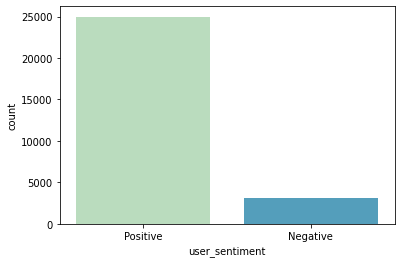

In [144]:
sns.countplot(x='user_sentiment', data=df, palette="GnBu")
plt.show()

In [145]:
df['reviews_rating'].describe()

count    28063.000000
mean         4.524427
std          0.931650
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: reviews_rating, dtype: float64

In [146]:
df['reviews_rating'].value_counts()

5    19855
4     5556
3     1221
1     1055
2      376
Name: reviews_rating, dtype: int64

<AxesSubplot:xlabel='reviews_rating', ylabel='count'>

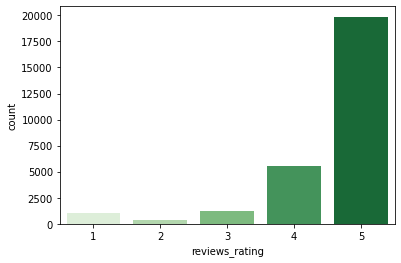

In [147]:
sns.countplot(x='reviews_rating', data= df, palette="Greens")

### Observation 
- There is high class imbalance in both ratings and sentiment favoring the poistive side.

### Decision
- During model building, we can use 'smote' to balance the datasets.

In [148]:
df.head(2)

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
0,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45,NaN,5,i love this album. it's very good. more to the...,joshua,Positive
1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00,NaN,5,Good flavor. This review was collected as part...,dorothy w,Positive


### Most common brands (Top 10)

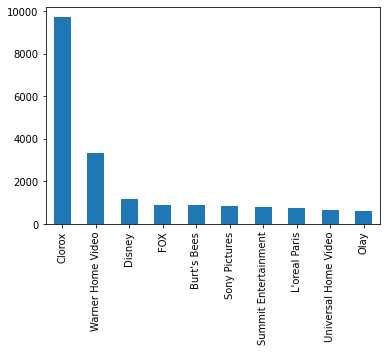

In [149]:
df['brand'].value_counts()[:10].plot(kind='bar')
plt.show()

In [150]:
most_common_brands = df['brand'].value_counts()[:10].index.to_list()

In [151]:
most_common_brands_df = df[df['brand'].isin(most_common_brands)]

In [152]:
# most_common_brands_df.head()

#### Brands againts ratings

In [153]:
most_common_brands_df.pivot_table(
    index='brand',
    values='reviews_rating',
    aggfunc='mean'
).sort_values(by='reviews_rating', ascending=False)#.plot(kind='barh')

,reviews_rating
brand,
Clorox,4.824406
Olay,4.689984
Disney,4.686717
Sony Pictures,4.674556
Burt's Bees,4.650397
Summit Entertainment,4.584975
Universal Home Video,4.491018
Warner Home Video,4.350677
FOX,4.335964


### Observation
- All top 10 brands have ratings above 4 stars
- Clorax has the highest ratings (4.82)

### Sentiment against Ratings

In [154]:
df['user_sentiment'].value_counts()

Positive    24964
Negative     3099
Name: user_sentiment, dtype: int64

In [155]:
pd.crosstab(index=df['reviews_rating'], columns=df['user_sentiment'])

user_sentiment,Negative,Positive
reviews_rating,,
1,459,596
2,131,245
3,206,1015
4,536,5020
5,1767,18088


In [156]:
df.pivot_table(
    index='user_sentiment',
    # columns='reviews_rating',
    values='reviews_rating'
)

,reviews_rating
user_sentiment,
Negative,3.974831
Positive,4.592653


#### Observation
The sentiment provided to us seems a bit off. The lower ratings should generally have negative sentiment associated with them.

In [157]:
df.loc[
    (df['user_sentiment']=='Positive')
    &
    (df['reviews_rating']<3)
    ]['reviews_text'].to_list()[0:3]

['Got as a surprise for my husband there is nothing special about it just a lube save the money and get plain KY if you just need a lube wish I could return it for a refund',
 "Purchased this thinking it would have some sort of warming effect but it's the same as the original. Don't waste your money.",
 'First time purchase of this type of product. Maybe I expected too much. Did not think there was any warming feeling at all. Left us sticky! Even after trying to was it off.']

In [158]:
df.loc[
    (df['user_sentiment']=='Negative')
    &
    (df['reviews_rating']<3)
    ]['reviews_text'].to_list()[0:3]

["I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",
 "My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.",
 'My boyfriend and I bought this to spice things up in the bedroom and we were both highly disappointed in this product. We bought this one because we absolutely 

In [159]:
df.loc[
    (df['user_sentiment']=='Negative')
    &
    (df['reviews_rating']>3)
    ]['reviews_text'].to_list()[0:3]

['It hydrates my skin. It is not too thick and heavy when I put it on. This review was collected as part of a promotion.',
 'In only a week I can see the difference in my skin on my face. This review was collected as part of a promotion.',
 'This product has made my skin smoother and supple after only two weeks. It absorbs well and leaves no residue. This review was collected as part of a promotion.']

### Decision
- We can remove 'This review was collected as part of a promotion.' from reviews_text. It does not provide any useful information for sentiment analysis
- We can apply a rating based rule to fix the sentiments of the reviews before building classification model.

In [160]:
df['reviews_text'] = df['reviews_text'].str.replace('This review was collected as part of a promotion.', '', regex=False)

In [161]:
df.loc[
    (df['user_sentiment']=='Negative')
    &
    (df['reviews_rating']>3)
    ]['reviews_text'].to_list()[0:3]

['It hydrates my skin. It is not too thick and heavy when I put it on. ',
 'In only a week I can see the difference in my skin on my face. ',
 'This product has made my skin smoother and supple after only two weeks. It absorbs well and leaves no residue. ']

In [162]:
# fixing sentiment. for rating==3, we are not updating existing sentiment.
df.loc[df['reviews_rating'] < 3, 'user_sentiment']='Negative'
df.loc[df['reviews_rating'] > 3, 'user_sentiment']='Positive'

In [163]:
pd.crosstab(index=df['reviews_rating'], columns=df['user_sentiment'])

user_sentiment,Negative,Positive
reviews_rating,,
1,1055,0
2,376,0
3,206,1015
4,0,5556
5,0,19855


In [164]:
df['name'].value_counts()[0:5]

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total              7821
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd        3325
Clorox Disinfecting Bathroom Cleaner                                   1905
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)    1142
Burt's Bees Lip Shimmer, Raisin                                         873
Name: name, dtype: int64

In [165]:
#def count_sentiment(prod_name, inp_sent):
#    return df[(df['name']==prod_name) & (df['user_sentiment'] == inp_sent)].count()[0]

---

## Text Processing and EDA on Reviews

#### Checking blank reviews

In [166]:
df['reviews_text'].isna().sum()

0

In [167]:
df[df['reviews_text'].str.strip() == ''].head()

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment


## Approach
- using stemmer for fast processing
- removing stopwords
- removing punctuations

In [168]:
stemmer = PorterStemmer()

# add stemming and lemmatisation in the preprocess function
def preprocess(document):
    'changes document to lower case and removes stopwords'

    # change sentence to lower case and strip characters
    document = document.lower().strip()

    # tokenize into words
    words = word_tokenize(document)

    # remove stop words and punctuation
    words = [word for word in words if word not in stopwords.words("english") and word.isalpha()]
    
    # stemming
    words = [stemmer.stem(word) for word in words]
    
    # join words to make sentence
    document = " ".join(words)
    
    return document

In [169]:
df['reviews_text'][0]

"i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy."

In [170]:
preprocess(df['reviews_text'][0])

'love album good hip hop side current pop sound hype listen everyday gym give rate way metaphor crazi'

In [171]:
%%time
df['reviews_clean'] = df['reviews_text'].apply(lambda x: preprocess(x))

CPU times: user 48 s, sys: 7.56 s, total: 55.5 s
Wall time: 55.5 s


In [172]:
joblib.dump(df, 'cleaned_df.gz')

['cleaned_df.gz']

In [173]:
df.head(2)

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,reviews_clean
0,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45,NaN,5,i love this album. it's very good. more to the...,joshua,Positive,love album good hip hop side current pop sound...
1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00,NaN,5,Good flavor.,dorothy w,Positive,good flavor


---

#### Visualize top words using word cloud

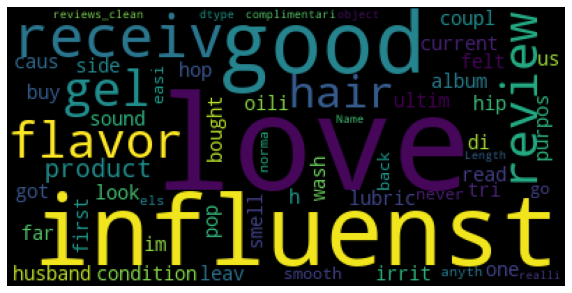

In [174]:
wordcloud = WordCloud(max_words=200).generate(str(df.reviews_clean))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Visualize number of words

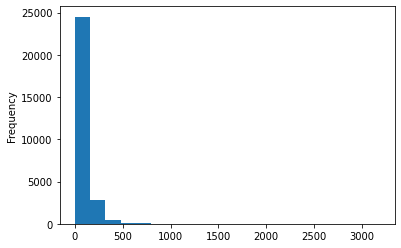

In [175]:
df.reviews_clean.str.len().plot(kind='hist', bins=20)
plt.show()

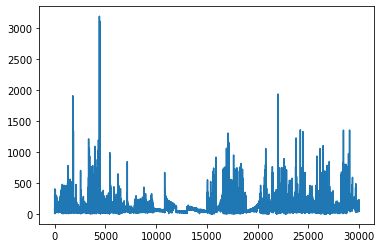

In [176]:
df.reviews_clean.str.len().plot()
plt.show()

In [177]:
df_reviews_list = df.reviews_clean.str.split()

In [178]:
df_reviews_word_count = df_reviews_list.apply(len)

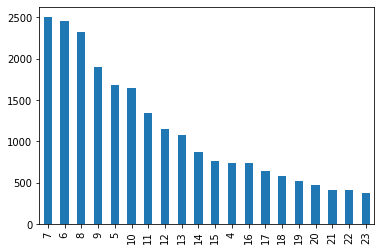

In [179]:
df_reviews_word_count.value_counts()[0:20].plot(kind='bar')
plt.show()

### Observation
Generally reviews seem to have very few relevant words (if we remove stopwords and punctuations)

In [180]:
all_words = ' '.join(df.reviews_clean).split()

In [181]:
from collections import Counter

In [182]:
Counter(all_words).most_common(10)

[('use', 11823),
 ('love', 9257),
 ('great', 8435),
 ('product', 8200),
 ('movi', 7575),
 ('clean', 7078),
 ('wipe', 6203),
 ('like', 4606),
 ('good', 4359),
 ('clorox', 4045)]

In [183]:
top_10_words = dict(Counter(all_words).most_common(10))

In [184]:
top_10_words

{'use': 11823,
 'love': 9257,
 'great': 8435,
 'product': 8200,
 'movi': 7575,
 'clean': 7078,
 'wipe': 6203,
 'like': 4606,
 'good': 4359,
 'clorox': 4045}

<AxesSubplot:>

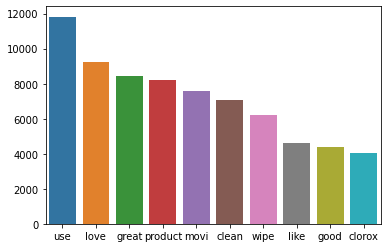

In [185]:
keys = list(top_10_words)
values = list(top_10_words.values())

sns.barplot(x=keys, y=values)

In [186]:
def extract_ngrams(data, num):
    n_grams = ngrams(nltk.word_tokenize(data), num)
    return [ ' '.join(grams) for grams in n_grams]

In [187]:
Counter(extract_ngrams(' '.join(all_words), 2)).most_common(10)

[('clorox wipe', 1856),
 ('easi use', 1211),
 ('use clorox', 976),
 ('love clorox', 858),
 ('use product', 823),
 ('love product', 775),
 ('great product', 774),
 ('disinfect wipe', 716),
 ('great movi', 679),
 ('smell great', 632)]

In [188]:
Counter(extract_ngrams(' '.join(all_words), 3)).most_common(10)

[('use clorox wipe', 499),
 ('clorox disinfect wipe', 466),
 ('love clorox wipe', 446),
 ('pleas bring back', 286),
 ('love use clorox', 212),
 ('wipe easi use', 197),
 ('get job done', 165),
 ('use clorox disinfect', 158),
 ('receiv product free', 154),
 ('product easi use', 148)]

In [189]:
Counter(extract_ngrams(' '.join(all_words), 3)).most_common(10)

[('use clorox wipe', 499),
 ('clorox disinfect wipe', 466),
 ('love clorox wipe', 446),
 ('pleas bring back', 286),
 ('love use clorox', 212),
 ('wipe easi use', 197),
 ('get job done', 165),
 ('use clorox disinfect', 158),
 ('receiv product free', 154),
 ('product easi use', 148)]

In [190]:
Counter(extract_ngrams(' '.join(all_words), 3)).most_common()[20:30]

[('love product use', 103),
 ('back old formula', 101),
 ('use clorox product', 98),
 ('clorox wipe conveni', 96),
 ('use product year', 94),
 ('everi room hous', 94),
 ('would definit recommend', 89),
 ('bring back cocoa', 89),
 ('would recommend product', 87),
 ('cocoa lip shimmer', 86)]

---

## Feature Extraction
- We will be using TF-IDF vectorizer
- Reason is lots of products have common words like "use" or "clorox" which means that we need something that is able to distinguish documents based on how many unique words it contains. TF-IDF is one search metric as it uses "Inverse Document Frequency" during calculation.

In [191]:
vectorizer = TfidfVectorizer(max_features=750, max_df=0.8, min_df=0.01, ngram_range=(1,3))
tfidf_model = vectorizer.fit_transform(df.reviews_clean)

In [192]:
# vectorizer.get_feature_names_out()

In [193]:
pd.DataFrame(tfidf_model.toarray(), columns = vectorizer.get_feature_names_out())

,abl,absolut,absolut love,action,actual,add,almost,also,alway,amaz,...,without,wonder,work,work great,work well,worth,would,would recommend,year,year old
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.178899,0.256573,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.249876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
28059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
28060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
28061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


### Changing sentiment to binary for training classification model

In [194]:
df.user_sentiment = df.user_sentiment.map({'Positive': 1, 'Negative': 0})

In [195]:
df.head(5)

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,reviews_clean
0,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45,NaN,5,i love this album. it's very good. more to the...,joshua,1,love album good hip hop side current pop sound...
1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00,NaN,5,Good flavor.,dorothy w,1,good flavor
2,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00,NaN,5,Good flavor.,dorothy w,1,good flavor
3,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00,False,1,I read through the reviews on here before look...,rebecca,0,read review look buy one coupl lubric ultim di...
4,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00,False,1,My husband bought this gel for us. The gel cau...,walker557,0,husband bought gel us gel caus irrit felt like...


In [196]:
sentiment_labels = df.user_sentiment

In [197]:
df.user_sentiment.value_counts(normalize=True)

1    0.941667
0    0.058333
Name: user_sentiment, dtype: float64

### Observation

- Very high class imbalance
- Must use SMOTE to fix

## Train Test Split

In [198]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_model, sentiment_labels, random_state=42, test_size=0.20)

In [199]:
counter = Counter(y_train)
print('Before SMOTE', counter)

sm = SMOTE()

# transform the dataset
X_train, y_train = sm.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After SMOTE',counter)

Before SMOTE Counter({1: 21142, 0: 1308})
After SMOTE Counter({1: 21142, 0: 21142})


In [200]:
class ModelBuilder:
    """Custom class to build models and evaluate scores quickly"""
    def __init__(self, model, x_train, x_test, y_train, y_test):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        
        
    def train_model(self):
        self.model.fit(self.x_train,self.y_train)
        return self.model.predict(self.x_test)
    
    def evaluate_model(self, y_pred_class):
        print("\n")
        print("=+"*15)
        self.result_metrics = self.evaluate_metrics(y_pred_class)
        print("=+"*15)
        print("\n")
        
        self.classification_report(y_pred_class)
        print("\n\n")
        print("=+="*15)
        print("\n")
        self.confusion_matrix(y_pred_class)
            
        print("=+="*15)
        print("\n")
        
        metrics.plot_roc_curve(self.model, self.x_test, self.y_test)
        
        return self.result_metrics
        
    def evaluate_metrics(self, y_pred_class):
        """
        - Accuracy
        - Precision
        - Recall
        - F1 Score
        - AUC Value
        """
        result_metrics = [] 
        accuracy = metrics.accuracy_score(self.y_test, y_pred_class)
        precision = metrics.precision_score(self.y_test, y_pred_class)
        recall = metrics.recall_score(self.y_test, y_pred_class)
        f1score = metrics.f1_score(self.y_test, y_pred_class)
        y_pred_prob = self.model.predict_proba(self.x_test)[:,1]
        roc_auc = metrics.roc_auc_score(self.y_test, y_pred_prob)

        print(f"Accuracy is : {accuracy*100:.1f}%")
        print(f"Precision is : {precision*100:.1f}%")
        print(f"Recall is : {recall*100:.1f}%")
        print(f"F1 Score is : {f1score*100:.1f}%")
        print(f"Roc-Auc Score is:{roc_auc*100:.1f}%")
        
        result_metrics.append(accuracy)
        result_metrics.append(precision)
        result_metrics.append(recall)
        result_metrics.append(f1score)
        result_metrics.append(roc_auc)
        return result_metrics
        
    def confusion_matrix(self, y_pred_class):
        confusion_matrix = metrics.confusion_matrix(self.y_test, y_pred_class)
        self.plot_confusion_matrix(confusion_matrix,[0,1])
        
        
    def plot_confusion_matrix(self, data, labels):
        sns.set(color_codes=True)
        plt.title("Confusion Matrix")
        ax = sns.heatmap(data/np.sum(data), annot=True, cmap="Reds", fmt=".2%")
 
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
 
        ax.set(ylabel="True Values", xlabel="Predicted Values")
        plt.show()
        
    def classification_report(self, y_pred_class):
        print(metrics.classification_report(self.y_test, y_pred_class))

## Logistic Regression

In [201]:
%time
logreg_ci = LogisticRegression(random_state=42, max_iter=100,solver='liblinear', class_weight="balanced")
lr_ci_modebuilder = ModelBuilder(logreg_ci, X_train, X_test, y_train, y_test)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 2.15 µs




=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Accuracy is : 87.6%
Precision is : 98.2%
Recall is : 88.5%
F1 Score is : 93.1%
Roc-Auc Score is:90.5%
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+


              precision    recall  f1-score   support

           0       0.28      0.73      0.41       329
           1       0.98      0.89      0.93      5284

    accuracy                           0.88      5613
   macro avg       0.63      0.81      0.67      5613
weighted avg       0.94      0.88      0.90      5613




=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




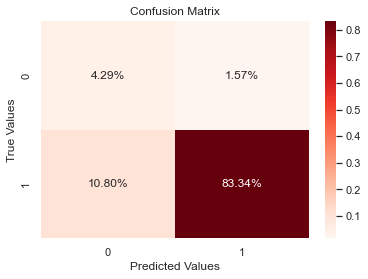

=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


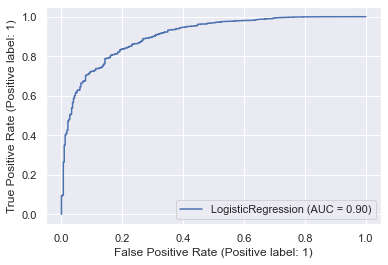

In [202]:
y_pred_class  = lr_ci_modebuilder.train_model()
lr_metrics = lr_ci_modebuilder.evaluate_model(y_pred_class)

In [203]:
y_train_pred = logreg_ci.predict(X_train)

In [204]:
thresholds = np.round(np.arange(0, 1, 0.1), 2)
threshold_df = generate_prob_threshold_df(y_train, logreg_ci.predict_proba(X_train), thresholds)

In [205]:
cutoff_df = generate_optimal_cutoff_df(threshold_df, thresholds)
cutoff_df.head()

,prob,accuracy,sensi,speci
0.0,0.0,0.500000,1.000000,0.000000
0.1,0.1,0.760548,0.982357,0.538738
0.2,0.2,0.847649,0.963863,0.731435
0.3,0.3,0.882745,0.942437,0.823054
0.4,0.4,0.897195,0.915760,0.878630


In [206]:
clf_df = classification_metrics(y_train, y_train_pred, 'logistic_train')
clf_df.head()

,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.89,0.92,0.9,0.91,0.89,0.89,0.11,0.08,0.9


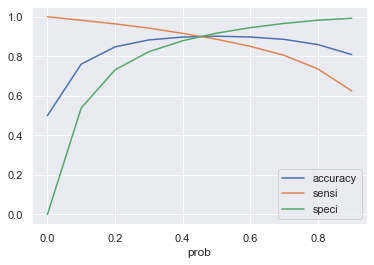

In [207]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [208]:
metrics_on_different_thresholds(y_train, thresholds, threshold_df)

,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0.0,1.0,0.0,0.5,0.5,1.0,1.0,0.0,1.0,0.67
0.1,0.98,0.54,0.76,0.68,0.98,0.98,0.02,0.46,0.8
0.2,0.96,0.73,0.85,0.78,0.96,0.96,0.04,0.27,0.86
0.3,0.94,0.82,0.88,0.84,0.94,0.94,0.06,0.18,0.89
0.4,0.92,0.88,0.9,0.88,0.92,0.92,0.08,0.12,0.9
0.5,0.89,0.92,0.9,0.91,0.89,0.89,0.11,0.08,0.9
0.6,0.85,0.94,0.9,0.94,0.85,0.85,0.15,0.06,0.89
0.7,0.8,0.97,0.89,0.96,0.8,0.8,0.2,0.03,0.88
0.8,0.74,0.98,0.86,0.98,0.74,0.74,0.26,0.02,0.84
0.9,0.62,0.99,0.81,0.99,0.62,0.62,0.38,0.01,0.77


#### Decision
0.5 seems to be optimal cut-off point

In [209]:
classification_metrics(y_train, threshold_df[0.5], 'logistic_train')

,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.89,0.92,0.9,0.91,0.89,0.89,0.11,0.08,0.9


In [210]:
threshold_df_test = generate_prob_threshold_df(y_test, logreg_ci.predict_proba(X_test), thresholds)
classification_metrics(y_test, threshold_df_test[0.5], 'logistic_test')

,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.89,0.73,0.88,0.98,0.89,0.89,0.11,0.27,0.93


---

## Naive Bayes



=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Accuracy is : 84.1%
Precision is : 98.1%
Recall is : 84.7%
F1 Score is : 90.9%
Roc-Auc Score is:88.5%
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+


              precision    recall  f1-score   support

           0       0.23      0.74      0.35       329
           1       0.98      0.85      0.91      5284

    accuracy                           0.84      5613
   macro avg       0.61      0.79      0.63      5613
weighted avg       0.94      0.84      0.88      5613




=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




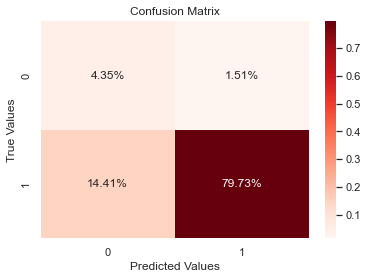

=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


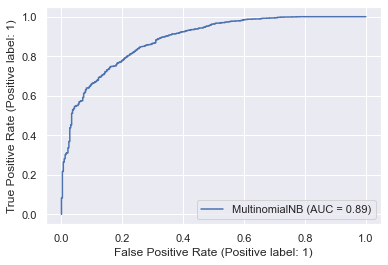

In [211]:
# training the NB model and making predictions
mnb = MultinomialNB()
mnb_modebuilder = ModelBuilder(mnb, X_train, X_test, y_train, y_test)
# Train and Predict the Test Labels
y_pred_class  = mnb_modebuilder.train_model()
nb_metrics = mnb_modebuilder.evaluate_model(y_pred_class)

In [212]:
thresholds = np.round(np.arange(0, 1, 0.1), 2)
threshold_df = generate_prob_threshold_df(y_train, mnb.predict_proba(X_train), thresholds)

In [213]:
cutoff_df = generate_optimal_cutoff_df(threshold_df, thresholds)
# cutoff_df.head()

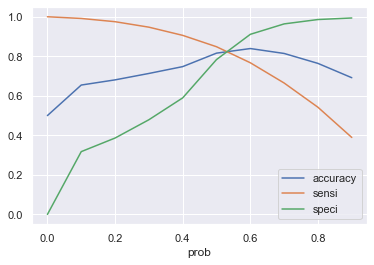

In [214]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [215]:
metrics_on_different_thresholds(y_train, thresholds, threshold_df)

,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0.0,1.0,0.0,0.5,0.5,1.0,1.0,0.0,1.0,0.67
0.1,0.99,0.32,0.65,0.59,0.99,0.99,0.01,0.68,0.74
0.2,0.97,0.39,0.68,0.61,0.97,0.97,0.03,0.61,0.75
0.3,0.95,0.48,0.71,0.65,0.95,0.95,0.05,0.52,0.77
0.4,0.91,0.59,0.75,0.69,0.91,0.91,0.09,0.41,0.78
0.5,0.85,0.78,0.82,0.8,0.85,0.85,0.15,0.22,0.82
0.6,0.77,0.91,0.84,0.9,0.77,0.77,0.23,0.09,0.83
0.7,0.66,0.96,0.81,0.95,0.66,0.66,0.34,0.04,0.78
0.8,0.54,0.99,0.76,0.97,0.54,0.54,0.46,0.01,0.7
0.9,0.39,0.99,0.69,0.98,0.39,0.39,0.61,0.01,0.56


#### Decision
0.5 seems to be optimal cut-off point

In [216]:
classification_metrics(y_train, threshold_df[0.5], 'naive_bayes_train')

,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.85,0.78,0.82,0.8,0.85,0.85,0.15,0.22,0.82


In [217]:
threshold_df_test = generate_prob_threshold_df(y_test, mnb.predict_proba(X_test), thresholds)
classification_metrics(y_test, threshold_df_test[0.5], 'naive_bayes_test')

,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.85,0.73,0.84,0.98,0.85,0.85,0.15,0.27,0.91


---

## Decision Tree



=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Accuracy is : 71.5%
Precision is : 98.2%
Recall is : 71.0%
F1 Score is : 82.4%
Roc-Auc Score is:80.2%
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+


              precision    recall  f1-score   support

           0       0.15      0.79      0.25       329
           1       0.98      0.71      0.82      5284

    accuracy                           0.71      5613
   macro avg       0.56      0.75      0.53      5613
weighted avg       0.93      0.71      0.79      5613




=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




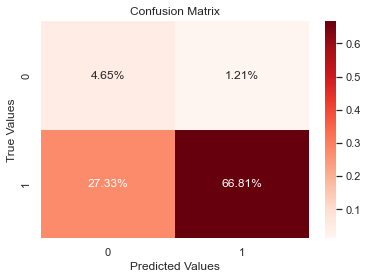

=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


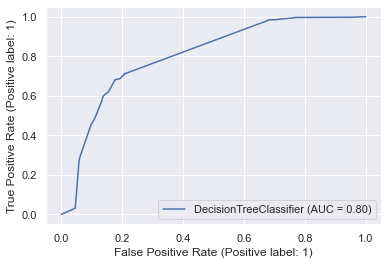

In [218]:
dt = DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=10)
dt_modelbuilder = ModelBuilder(dt, X_train, X_test, y_train, y_test)
y_pred_class  = dt_modelbuilder.train_model()
dt_metrics_cv = dt_modelbuilder.evaluate_model(y_pred_class)

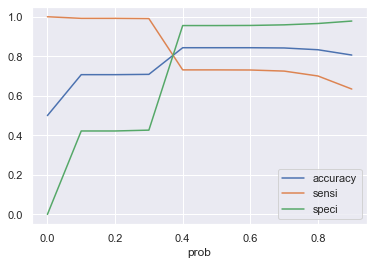

In [219]:
thresholds = np.round(np.arange(0, 1, 0.1), 2)
threshold_df = generate_prob_threshold_df(y_train, dt.predict_proba(X_train), thresholds)

cutoff_df = generate_optimal_cutoff_df(threshold_df, thresholds)
# cutoff_df.head()

# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [220]:
metrics_on_different_thresholds(y_train, thresholds, threshold_df)

,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0.0,1.0,0.0,0.5,0.5,1.0,1.0,0.0,1.0,0.67
0.1,0.99,0.42,0.71,0.63,0.99,0.99,0.01,0.58,0.77
0.2,0.99,0.42,0.71,0.63,0.99,0.99,0.01,0.58,0.77
0.3,0.99,0.43,0.71,0.63,0.99,0.99,0.01,0.57,0.77
0.4,0.73,0.96,0.84,0.94,0.73,0.73,0.27,0.04,0.82
0.5,0.73,0.96,0.84,0.94,0.73,0.73,0.27,0.04,0.82
0.6,0.73,0.96,0.84,0.94,0.73,0.73,0.27,0.04,0.82
0.7,0.73,0.96,0.84,0.95,0.73,0.73,0.27,0.04,0.82
0.8,0.7,0.97,0.83,0.95,0.7,0.7,0.3,0.03,0.81
0.9,0.63,0.98,0.81,0.97,0.63,0.63,0.37,0.02,0.77


#### Decision
0.6 seems to be optimal cut-off point

In [221]:
classification_metrics(y_train, threshold_df[0.6], 'dt_train')

,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.73,0.96,0.84,0.94,0.73,0.73,0.27,0.04,0.82


In [222]:
threshold_df_test = generate_prob_threshold_df(y_test, dt.predict_proba(X_test), thresholds)
classification_metrics(y_test, threshold_df_test[0.6], 'dt_test')

,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.71,0.79,0.71,0.98,0.71,0.71,0.29,0.21,0.82


---

## Random Forest
(with hyperparameter tuning)

In [223]:
rf = RandomForestClassifier(oob_score=True, random_state=42, criterion="gini")
params = {
    'max_depth': [2,3,5,10],
    'min_samples_leaf': [5,10,20,50],
    'n_estimators': [10, 25, 50, 100]
}
grid_search = RandomizedSearchCV(estimator=rf,
                           param_distributions=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="f1")
%time
grid_search.fit(X_train, y_train)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs
Fitting 4 folds for each of 10 candidates, totalling 40 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  wa

RandomizedSearchCV(cv=4,
                   estimator=RandomForestClassifier(oob_score=True,
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 5, 10],
                                        'min_samples_leaf': [5, 10, 20, 50],
                                        'n_estimators': [10, 25, 50, 100]},
                   scoring='f1', verbose=1)



=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Accuracy is : 88.8%
Precision is : 97.5%
Recall is : 90.4%
F1 Score is : 93.8%
Roc-Auc Score is:88.9%
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+


              precision    recall  f1-score   support

           0       0.29      0.64      0.40       329
           1       0.98      0.90      0.94      5284

    accuracy                           0.89      5613
   macro avg       0.63      0.77      0.67      5613
weighted avg       0.94      0.89      0.91      5613




=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




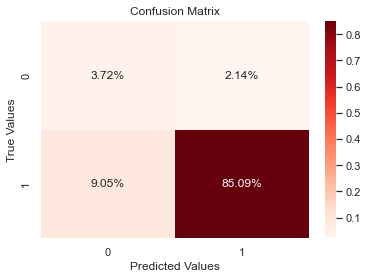

=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


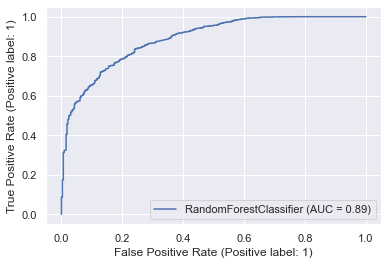

In [224]:
rf_best = grid_search.best_estimator_
rf_modebuilder = ModelBuilder(rf_best, X_train, X_test, y_train, y_test)
# Train and Predict the Test Labels
y_pred_class  = rf_modebuilder.train_model()
rf_metrics = rf_modebuilder.evaluate_model(y_pred_class)

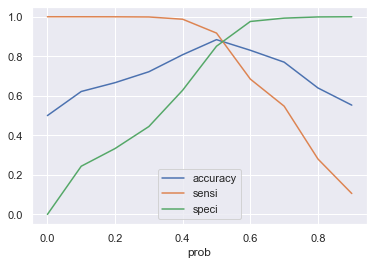

In [225]:
thresholds = np.round(np.arange(0, 1, 0.1), 2)
threshold_df = generate_prob_threshold_df(y_train, rf_best.predict_proba(X_train), thresholds)

cutoff_df = generate_optimal_cutoff_df(threshold_df, thresholds)
# cutoff_df.head()

# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [226]:
metrics_on_different_thresholds(y_train, thresholds, threshold_df)

,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0.0,1.0,0.0,0.5,0.5,1.0,1.0,0.0,1.0,0.67
0.1,1.0,0.24,0.62,0.57,1.0,1.0,0.0,0.76,0.73
0.2,1.0,0.33,0.67,0.6,1.0,1.0,0.0,0.67,0.75
0.3,1.0,0.44,0.72,0.64,1.0,1.0,0.0,0.56,0.78
0.4,0.99,0.63,0.81,0.73,0.99,0.99,0.01,0.37,0.84
0.5,0.92,0.85,0.88,0.86,0.92,0.92,0.08,0.15,0.89
0.6,0.68,0.98,0.83,0.97,0.68,0.68,0.32,0.02,0.8
0.7,0.55,0.99,0.77,0.99,0.55,0.55,0.45,0.01,0.7
0.8,0.28,1.0,0.64,1.0,0.28,0.28,0.72,0.0,0.44
0.9,0.11,1.0,0.55,1.0,0.11,0.11,0.89,0.0,0.19


#### Decision
0.5 seems to be optimal cut-off point

In [227]:
classification_metrics(y_train, threshold_df[0.5], 'rf_train')

,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.92,0.85,0.88,0.86,0.92,0.92,0.08,0.15,0.89


In [228]:
threshold_df_test = generate_prob_threshold_df(y_test, rf_best.predict_proba(X_test), thresholds)
classification_metrics(y_test, threshold_df_test[0.5], 'rf_test')

,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.9,0.64,0.89,0.98,0.9,0.9,0.1,0.36,0.94


---

## XGBOOST



=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Accuracy is : 92.2%
Precision is : 97.3%
Recall is : 94.3%
F1 Score is : 95.8%
Roc-Auc Score is:89.7%
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+


              precision    recall  f1-score   support

           0       0.39      0.59      0.47       329
           1       0.97      0.94      0.96      5284

    accuracy                           0.92      5613
   macro avg       0.68      0.76      0.71      5613
weighted avg       0.94      0.92      0.93      5613




=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




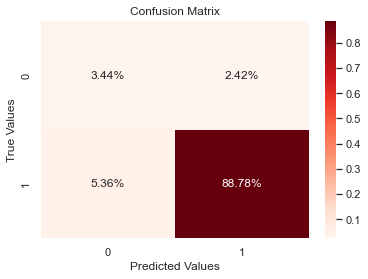

=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


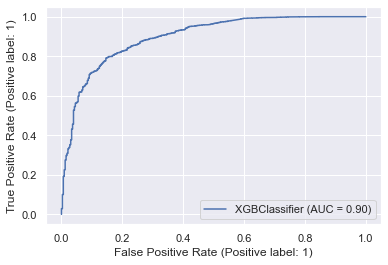

In [229]:
xgclf = xgb.XGBClassifier(learning_rate=0.20, max_depth=8, random_state=42) #based on the tuned parameters
xg_modebuilder = ModelBuilder(xgclf, X_train, X_test, y_train, y_test)
# Train and Predict the Test Labels
y_pred_class  = xg_modebuilder.train_model()
xg_metrics = xg_modebuilder.evaluate_model(y_pred_class)

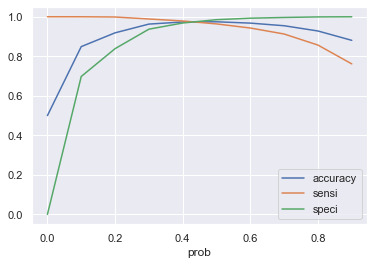

In [230]:
thresholds = np.round(np.arange(0, 1, 0.1), 2)
threshold_df = generate_prob_threshold_df(y_train, xgclf.predict_proba(X_train), thresholds)

cutoff_df = generate_optimal_cutoff_df(threshold_df, thresholds)
# cutoff_df.head()

# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [231]:
metrics_on_different_thresholds(y_train, thresholds, threshold_df)

,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0.0,1.0,0.0,0.5,0.5,1.0,1.0,0.0,1.0,0.67
0.1,1.0,0.7,0.85,0.77,1.0,1.0,0.0,0.3,0.87
0.2,1.0,0.84,0.92,0.86,1.0,1.0,0.0,0.16,0.92
0.3,0.99,0.94,0.96,0.94,0.99,0.99,0.01,0.06,0.96
0.4,0.98,0.97,0.97,0.97,0.98,0.98,0.02,0.03,0.97
0.5,0.96,0.99,0.97,0.98,0.96,0.96,0.04,0.01,0.97
0.6,0.94,0.99,0.97,0.99,0.94,0.94,0.06,0.01,0.97
0.7,0.91,1.0,0.95,1.0,0.91,0.91,0.09,0.0,0.95
0.8,0.86,1.0,0.93,1.0,0.86,0.86,0.14,0.0,0.92
0.9,0.76,1.0,0.88,1.0,0.76,0.76,0.24,0.0,0.86


#### Decision
0.4 seems to be optimal cut-off point

In [232]:
classification_metrics(y_train, threshold_df[0.4], 'xg_train')

,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.98,0.97,0.97,0.97,0.98,0.98,0.02,0.03,0.97


In [233]:
threshold_df_test = generate_prob_threshold_df(y_test, xgclf.predict_proba(X_test), thresholds)
classification_metrics(y_test, threshold_df_test[0.4], 'xg_test')

,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
0,0.96,0.54,0.93,0.97,0.96,0.96,0.04,0.46,0.96


---

### Summarize Model Performance and Choose best classification Model

In [234]:
# Creating a table which contain all the metrics

metrics_table = {
    'Metric': ['Accuracy','Precision','Recall', 'F1Score','Auc Score'], 
    'Logistic Regression': lr_metrics,
    'Naive Bayes': nb_metrics,
    'Decision Tree': dt_metrics_cv,
    'Random Forrest': rf_metrics,
    'XG Boost': xg_metrics
}

df_metrics = pd.DataFrame(metrics_table,
                    columns = [
                              'Metric', 
                              'Logistic Regression', 
                              'Naive Bayes',
                              'Decision Tree',
                              'Random Forrest',
                              'XG Boost'
                    ])

df_metrics

,Metric,Logistic Regression,Naive Bayes,Decision Tree,Random Forrest,XG Boost
0,Accuracy,0.876358,0.840727,0.714591,0.888117,0.922145
1,Precision,0.981536,0.981360,0.982190,0.975490,0.973432
2,Recall,0.885314,0.846896,0.709690,0.903861,0.943036
3,F1Score,0.930945,0.909183,0.823995,0.938310,0.957993
4,Auc Score,0.904664,0.885184,0.802282,0.888602,0.897213


In [235]:
model_scores_df = pd.DataFrame(model_scores_dict.values(), index=model_scores_dict.keys(), columns=clf_df.columns)
model_scores_df

,sensitivity,specificity,accuracy,precision,recall,TPR,FNR,FPR,F1_score
logistic_train,0.89,0.92,0.90,0.91,0.89,0.89,0.11,0.08,0.90
logistic_test,0.89,0.73,0.88,0.98,0.89,0.89,0.11,0.27,0.93
naive_bayes_train,0.85,0.78,0.82,0.80,0.85,0.85,0.15,0.22,0.82
naive_bayes_test,0.85,0.73,0.84,0.98,0.85,0.85,0.15,0.27,0.91
dt_train,0.73,0.96,0.84,0.94,0.73,0.73,0.27,0.04,0.82
dt_test,0.71,0.79,0.71,0.98,0.71,0.71,0.29,0.21,0.82
rf_train,0.92,0.85,0.88,0.86,0.92,0.92,0.08,0.15,0.89
rf_test,0.90,0.64,0.89,0.98,0.90,0.90,0.10,0.36,0.94
xg_train,0.98,0.97,0.97,0.97,0.98,0.98,0.02,0.03,0.97
xg_test,0.96,0.54,0.93,0.97,0.96,0.96,0.04,0.46,0.96


Among all the options, the train score was highest with xgboost, however, the test score is poor which signals at overfitting especially looking at FPR.

After carefully studying the options, it seems `naive bayes` model might be the best as even though it is has low scores in some metrics, overall it is perfoming okay and test/train scores are similar indicating that the model is actually learning something as opposed to mugging up training data.

### Decision
Picking `Naive Bayes` based model

In [236]:
joblib.dump(mnb, 'mnb.pkl')

['mnb.pkl']

---

## Recommendation System
- User based Collaborative Filtering
- Item based Collaborative Filtering

### Divide data in train and test

In [237]:
train, test = train_test_split(df, test_size=0.30, random_state=31)

In [238]:
train.shape, test.shape

((19644, 11), (8419, 11))

## User Based

In [239]:
# Pivot the train ratings' dataset into matrix format in which columns are movies and the rows are user IDs.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating',
    # aggfunc='mean'
).fillna(0)

df_pivot.head(3)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Creating dummy train and test dataset
- Dummy Train will be used for prediction
    - To ignore products rated by the user we will mark it as 0 during prediction
    - products not rated by the user will be marked as 1
- Dummy Test will be used for evaluation
    - To evaluate, we will only make prediction on products rated by user
    - The 0/1 marking will be opposite to the train set

In [240]:
dummy_train = train.copy()
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [241]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(1)

In [242]:
dummy_train.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#### Cosine Similarity
- This is used to measure similarity between two vectors

#### Adjusted Cosine
- Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. 
    - some users might rate items highly in general, and 
    - others might give items lower ratings as a preference. 
- To handle this nature from rating given by user, we subtract average ratings for each user from each user's rating for different products.

In [243]:
# Here, we are not removing the NaN values and 
# calculating the mean only for the products rated by the user
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
)

In [244]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [245]:
# df_subtracted.head()

In [246]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [247]:
user_correlation.shape

(17875, 17875)

#### Prediction - User User
Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0. 

In [248]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the dataset). 

In [249]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.70121431, 0.        , ..., 2.01388889, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [250]:
user_predicted_ratings.shape

(17875, 249)

Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero. 

In [251]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
00sab00,0.0,3.701214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.098076,...,0.0,0.0,0.0,0.0,2.013889,0.0,0.0,2.013889,0.0,0.0
01impala,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
0325home,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
06stidriver,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


### Finding the top 5 recommendation for the *user*

In [252]:
user_inp = '00sab00'

In [253]:
d = user_final_rating.loc[user_inp].sort_values(ascending=False)[0:5]
d

name
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd        46.965060
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)    36.254539
The Resident Evil Collection 5 Discs (blu-Ray)                         18.161479
Red (special Edition) (dvdvideo)                                       10.637057
Bisquick Original Pancake And Baking Mix - 40oz                         7.434345
Name: 00sab00, dtype: float64

### Evaluation - User User 
- Here we will consider products already rated by the user

In [254]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1290, 11)

In [255]:
common.head(2)

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,reviews_clean
24918,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventur...",Test,Godzilla 3d Includes Digital Copy Ultraviolet ...,2014-09-19T00:00:00,True,5,I was expecting junk but this movie rocks! Pic...,john,1,expect junk movi rock pick
19220,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2013-10-23T00:00:00,True,5,These are so convenient and work well for smal...,mommaof4,1,conveni work well small easi mess well big who...


In [256]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [257]:
df_subtracted.head(1)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [258]:
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17865,17866,17867,17868,17869,17870,17871,17872,17873,17874
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [259]:
list_name = common.reviews_username.tolist()
user_correlation_df.columns = df_subtracted.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [260]:
user_correlation_df_1.shape

(1008, 17875)

In [261]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T
user_correlation_df_3.head()

,1234,123charlie,143st,1943,1witch,aaron,abbey,abby,abc,ac94,...,wolverine,wonster67,woottos,worm,xavier,xstr8edgex,yohnie1,yummy,zipper,zmom
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [262]:
user_correlation_df_3.shape

(1008, 1008)

In [263]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [264]:
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

In [265]:
dummy_test.shape

(1008, 122)

In [266]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_predicted_ratings.head(2)

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.","Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",...,Tresemme Kertatin Smooth Infusing Conditioning,Various - Country's Greatest Gospel:Gold Ed (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range.

In [267]:
X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [268]:
common_ = common.pivot_table(index='reviews_username', 
                             columns='name', 
                             values='reviews_rating')

In [269]:
total_non_nan = np.count_nonzero(~np.isnan(y))

In [270]:
common_.head(1)

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.","Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",...,Tresemme Kertatin Smooth Infusing Conditioning,Various - Country's Greatest Gospel:Gold Ed (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### RMSE - User User

In [271]:
((((common_ - y)**2).sum().sum())/total_non_nan)**0.5

2.309200158622194

---

## Item Based Similarity
Taking the transpose of the rating matrix to normalize the rating around the mean for different product ID. In the user based similarity, we had taken mean for each user instead of each product. 

In [272]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).T

df_pivot.head()

reviews_username,00dog3,00sab00,01impala,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,...,zsarah,zsazsa,zt313,zubb,zuttle,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalising the product rating for each product for using the Adujsted Cosine

In [273]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head(2)

reviews_username,00dog3,00sab00,01impala,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,...,zsarah,zsazsa,zt313,zubb,zuttle,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,0.284884,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finding the cosine similarity using pairwise distances approach

In [274]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [275]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

## Prediction - Item Item

In [276]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.0218914 , 0.        ,
        0.        ],
       [0.        , 0.01955435, 0.        , ..., 0.01617261, 0.        ,
        0.        ],
       [0.        , 0.02599812, 0.        , ..., 0.        , 0.        ,
        0.00074728],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01947735, 0.        , ..., 0.02695436, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [277]:
item_predicted_ratings.shape

(17875, 249)

In [278]:
dummy_train.shape

(17875, 249)

### Filtering the rating only for the products not rated by the user for recommendation

In [279]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.021891,0.0,0.000000
00sab00,0.0,0.019554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016284,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.016173,0.0,0.000000
01impala,0.0,0.025998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.002688,0.002964,0.0,0.0,0.000000,0.0,0.000747
0325home,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
06stidriver,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000


### Finding the top 5 recommendation for the *user*

In [280]:
user_inp = '00sab00'

In [281]:
# Recommending the Top 5 products to the user.
d = item_final_rating.loc[user_inp].sort_values(ascending=False)[0:5]
d

name
Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)    0.107178
Equals (blu-Ray)                                                0.051180
Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans                 0.050313
D-Con Mice Bait Station - 3ct                                   0.043815
Chex Muddy Buddies Brownie Supreme Snack Mix                    0.034658
Name: 00sab00, dtype: float64

### Evaluation - Item Item

- Considering the product already rated by the user insead of predicting it for the product not rated by the user. 

In [282]:
test.columns

Index(['brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_doRecommend', 'reviews_rating', 'reviews_text',
       'reviews_username', 'user_sentiment', 'reviews_clean'],
      dtype='object')

In [283]:
common =  test[test.name.isin(train.name)]
common.shape

(8391, 11)

In [284]:
common.head(4)

,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment,reviews_clean
19477,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-28T00:00:00,True,5,this product worked great. its smelled wonderf...,cleaner83,1,product work great smell wonder still work rea...
13452,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-02-19T00:00:00,True,5,"We LOVE clorox! It's so easy to use, and conve...",lauray,1,love clorox easi use conveni even year old hel...
13038,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-01-06T00:00:00,True,5,Cleans well..disinfects,meli05,1,clean well disinfect
9001,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-02-04T02:57:30,True,5,"i work at a vet hospital, and we use these wip...",hampstah,1,work vet hospit use wipe like crazi deal publi...


In [285]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T
common_item_based_matrix.shape

(192, 7956)

In [286]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,239,240,241,242,243,244,245,246,247,248
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [287]:
item_correlation_df['name'] = df_subtracted.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,239,240,241,242,243,244,245,246,247,248
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [288]:
list_name = common.name.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()
item_correlation_df_1 = item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
item_correlation_df_3 = item_correlation_df_2.T
item_correlation_df_3.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4",...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
Africa's Best No-Lye Dual Conditioning Relaxer System Super,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
Alex Cross (dvdvideo),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00345,0.0,0.0


In [289]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0433302 , 0.03466416, 0.0393397 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00260439, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00124547, 0.00099638, 0.        , ..., 0.00120641, 0.        ,
        0.        ]])

In [290]:
common_item_predicted_ratings.shape

(192, 7956)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train



In [291]:
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.

In [292]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [293]:
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [294]:
total_non_nan = np.count_nonzero(~np.isnan(y))

#### RMSE - Item Item

In [295]:
((((common_ - y)**2).sum().sum())/total_non_nan)**0.5

3.5804363870516522

### Observation
- the RMSE value for `user based recommendation engine` is better
- Additionally, looking at the `user_final_rating` and `item_final_rating` outputs for some users makes it seem that `user based` system will have more (correct) matching results for this database.

### Decision
#### Choosing `user based collaborative filtering` for Recommendation Engine

---

# References
- https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html
- https://stackoverflow.com/questions/57708107/pandas-to-datetime-function-doesnt-change-dtype
- https://stackoverflow.com/questions/38916452/nltk-download-ssl-certificate-verify-failed
- https://stackoverflow.com/questions/4743035/how-to-get-the-least-common-element-in-a-list
- https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
- https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
- https://datascience.stackexchange.com/questions/33730/should-i-rescale-tfidf-features